# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import json
import numpy as np
import pandas as pd
import numpyro, jax
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time

num_chains = 10
numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)

In [2]:
try:
    gpu = jax.devices('gpu')[0]
except RuntimeError:
    gpu = None

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Then, import the `HierarchicalStarModel` from `celestify`.

In [3]:
from celestify.numpyro_models import HierarchicalStarModel

2024-03-04 16:16:38.490675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 16:16:38.490704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 16:16:38.491562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 16:16:39.083651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [4]:
rng = random.PRNGKey(1)  # create random key to use throughout notebook

In [5]:
filename = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/truths-nearest-neighbour.csv"
df = pd.read_csv(filename, index_col=0)
df

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
5135942   4716    64    1.21899  0.255556  0.004416  1.789752  0.000315   
1047516    572   114    1.18823  0.256612  0.003238  2.030292  0.000000   
2374686   2422   832    1.86401  0.255684  0.004760  2.040546  0.014332   
4145653   6183   102    0.94165  0.278359  0.022493  1.983209  0.000000   
3861544   1731   120    1.15933  0.285274  0.023931  1.880585  0.000000   
...        ...   ...        ...       ...       ...       ...       ...   
1854696   3799   380    1.00815  0.273238  0.009368  2.062762  0.000000   
1322310    988   363    1.10386  0.263838  0.005982  1.950995  0.000000   
5302278   4984   160    0.96587  0.255751  0.002633  2.033112  0.000000   
1322043    988    96    1.10386  0.263838  0.005982  1.950995  0.000000   
3226063   5735   149    0.92134  0.274941  0.019122  2.148639  0.000000   

         fov_shell      star_age    radius  ...     log_g     log_L   delta_X  \
5135942   0.006041  2.053233e+09  1.370623  ...  4.250232  0.661895  0.529330   
1047516   0.006041  2.775791e+09  1.465378  ...  4.181069  0.764061  0.739037   
2374686   0.006041  9.790699e+08  5.314918  ...  3.257523  1.560242  0.739556   
4145653   0.006041  9.238255e+09  0.968621  ...  4.439649 -0.120005  0.487927   
3861544   0.006041  5.699361e+09  1.477156  ...  4.163422  0.375042  0.690712   
...            ...           ...       ...  ...       ...       ...       ...   
1854696   0.006041  8.890225e+09  4.576233  ...  3.120576  1.045949  0.717394   
1322310   0.006041  5.476578e+09  3.620299  ...  3.363493  0.890947  0.730180   
5302278   0.006041  5.988625e+09  1.347535  ...  4.163906  0.476824  0.738460   
1322043   0.006041  3.676525e+09  1.416278  ...  4.178685  0.524092  0.713508   
3226063   0.006041  1.343972e+10  1.080664  ...  4.335107  0.019266  0.696026   

            f_nuc  phase       EEP   bol_mag     abs_G    abs_BP    abs_RP  
5135942  1.000192      0  0.097247  3.095263  3.064094  3.207612  2.798840  
1047516  1.000001      0  0.169591  2.839847  2.821199  2.948562  2.583362  
2374686  1.057949      0  0.368276  0.849395  0.779131  1.029182  0.371158  
4145653  0.999883      0  0.105998  5.050013  4.977653  5.352141  4.440660  
3861544  1.000128      0  0.142149  3.812396  3.704555  4.010748  3.236899  
...           ...    ...       ...       ...       ...       ...       ...  
1854696  0.996020      0  0.557015  2.135128  2.173508  2.641750  1.550712  
1322310  0.996985      0  0.411047  2.522632  2.538278  2.968419  1.946027  
5302278  0.999890      0  0.207278  3.557939  3.528134  3.732733  3.169455  
1322043  1.000010      0  0.135843  3.439769  3.378705  3.585201  3.021342  
3226063  0.999994      0  0.169971  4.701836  4.620347  4.967586  4.109136  

[100000 rows x 36 columns]

In [6]:
df["L"] = 10**df["log_L"]
df["log_age"] = df["log_star_age"] - 9
df["age"] = 10**df["log_age"]
df["log_numax"] = df["log_g"] - HierarchicalStarModel.log_g_sun - 0.5 * (df["log_Teff"] - HierarchicalStarModel.log_teff_sun) + HierarchicalStarModel.log_numax_sun
df["numax"] = 10**df["log_numax"]

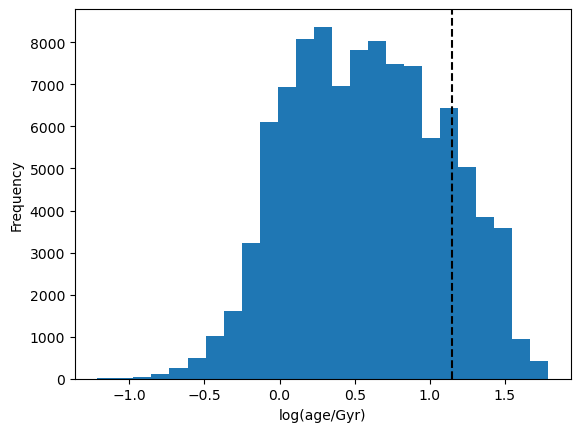

In [7]:
ax = df.log_age.plot(kind="hist", bins=25)
ax.axvline(np.log10(14), c="k", ls="--")
ax.set_xlabel("log(age/Gyr)");

In [8]:
truths_filepath = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/truths.json"
# SAVE TRUTHS
with open(truths_filepath, "r") as file:
    s = file.read()
    truths = json.loads(s)

In [9]:
# num_stars = 10
# hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]

# mask = np.less(truths["Teff"], 7500) & np.less(truths["age"], 14)
# truths = {key: np.array(value)[mask][:num_stars] if np.ndim(value) > 0 else value for key, value in truths.items()}
# truths["L"] = 10**truths["log_L"]

In [10]:
num_stars = 50

hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]
truths = {key: truths[key] for key in hyperparam_names}

rename_cols = {
    "EEP": "evol",
    "star_mass": "mass",
    "log_star_mass": "log_mass",
    "Yinit": "Y",
    "amlt": "a_MLT",
    "radius": "R",
    "log_radius": "log_R",
    "Dnu_freq_o": "Dnu",
    "log_Dnu_freq_o": "log_Dnu",
}

mask = (df.Teff < 7500.) & (df.age < 14.)
truths_ = df.loc[mask].iloc[:num_stars].rename(rename_cols, axis=1).to_dict(orient="list")
truths.update({key: np.array(value) for key, value in truths_.items()})
truths["y"] = np.stack([truths[key] for key in HierarchicalStarModel.outputs], -1)

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [11]:
observables = ["log_Teff", "log_L"]

rng, key = random.split(rng)
sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
}

# Create model
model = HierarchicalStarModel(num_stars, observables, const=const)

pprint(model.const)  # check all constants

2024-03-04 16:17:02.672036: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


{'M_H': {'loc': Array([-0.56478638, -0.45294576, -0.51104496,  0.42248729,  0.44980555,
        0.38064708, -0.85178703,  0.13576464, -0.63549865,  0.04088064,
       -0.33895044, -0.30513926,  0.19281561, -0.34389139,  0.0031867 ,
       -0.34715593,  0.36314832, -0.22678504,  0.04236311,  0.39023873,
       -0.22124479, -0.06223608,  0.34634971,  0.34841093, -0.44764267,
       -0.00320475, -0.00522213, -0.36453354, -0.4673207 , -0.03834732,
        0.15223112,  0.33615008,  0.07544266, -0.52265361, -0.07145736,
        0.30235956,  0.10037959, -0.09652371,  0.17930904,  0.15540315,
        0.32094266, -0.43493308, -0.11092504, -0.29896627,  0.34821412,
        0.36300951,  0.17957595, -0.85888035, -0.04229465,  0.1867912 ],      dtype=float64),
         'scale': 0.1},
 'Y': {'high': 0.32, 'low': 0.22},
 'Y_0': {'loc': 0.247, 'scale': 0.001},
 'a_MLT': {'high': 2.7, 'low': 1.3},
 'dY_dZ': {'high': 3.0, 'loc': 1.5, 'low': 0.0, 'scale': 0.5},
 'delta': {'cov': Array([[ 2.48329366e-06, 

## Prior Predictive

Sample from the model prior.

In [12]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
with jax.default_device(gpu):
    prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [13]:
coords = {"star": np.arange(num_stars), "output": model.outputs}
dims = {}
for key, value in prior_samples.items():
    dims[key] = dim = []
    if value.ndim == 1:
        continue
    if value.shape[1] == num_stars:
        dim.append("star")
    if value.shape[-1] == len(model.outputs):
        dim.append("output")

data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

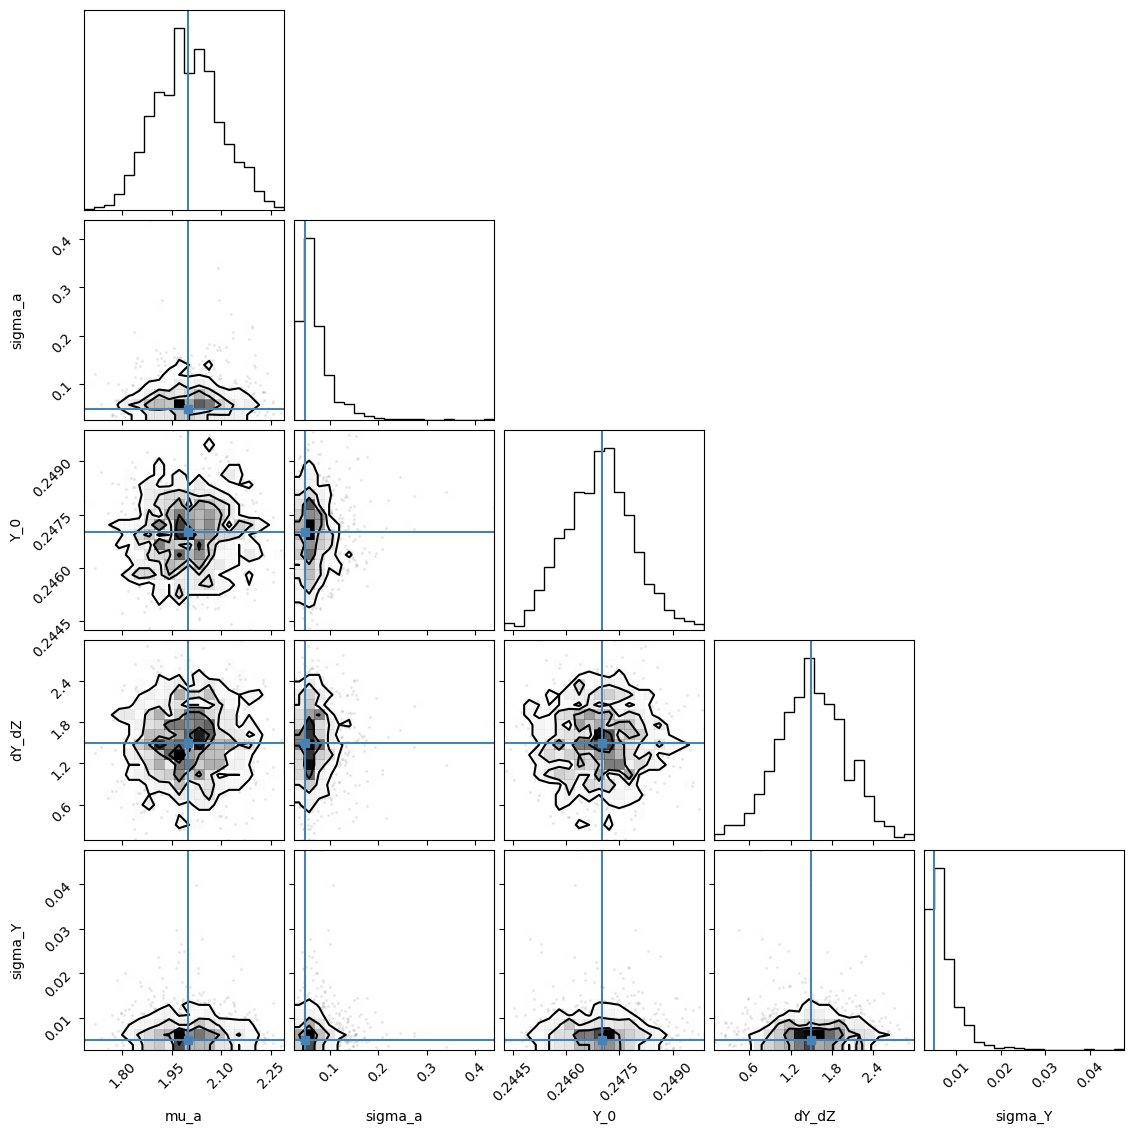

In [14]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

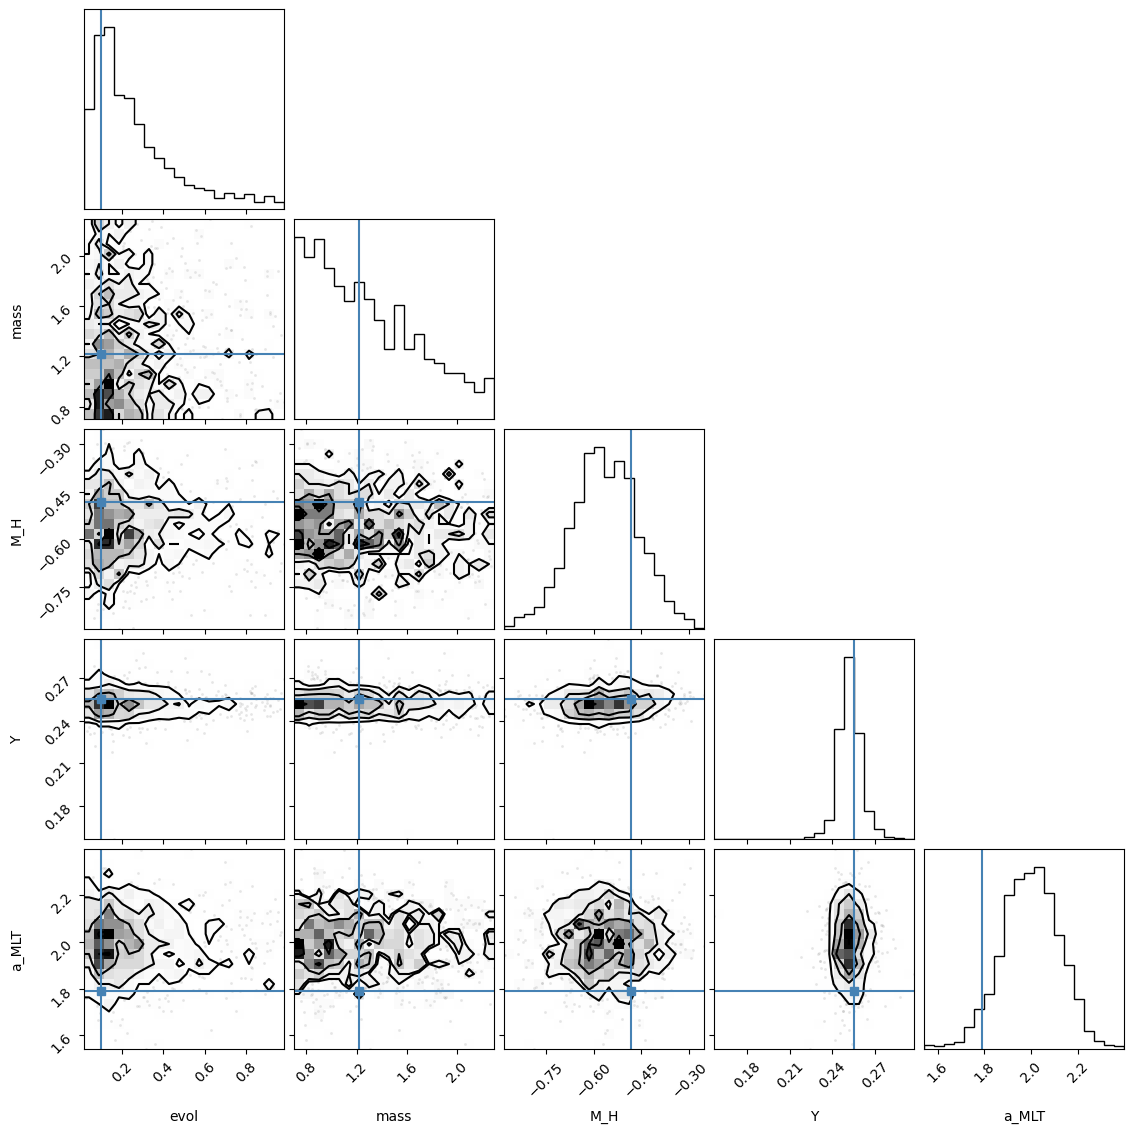

In [15]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

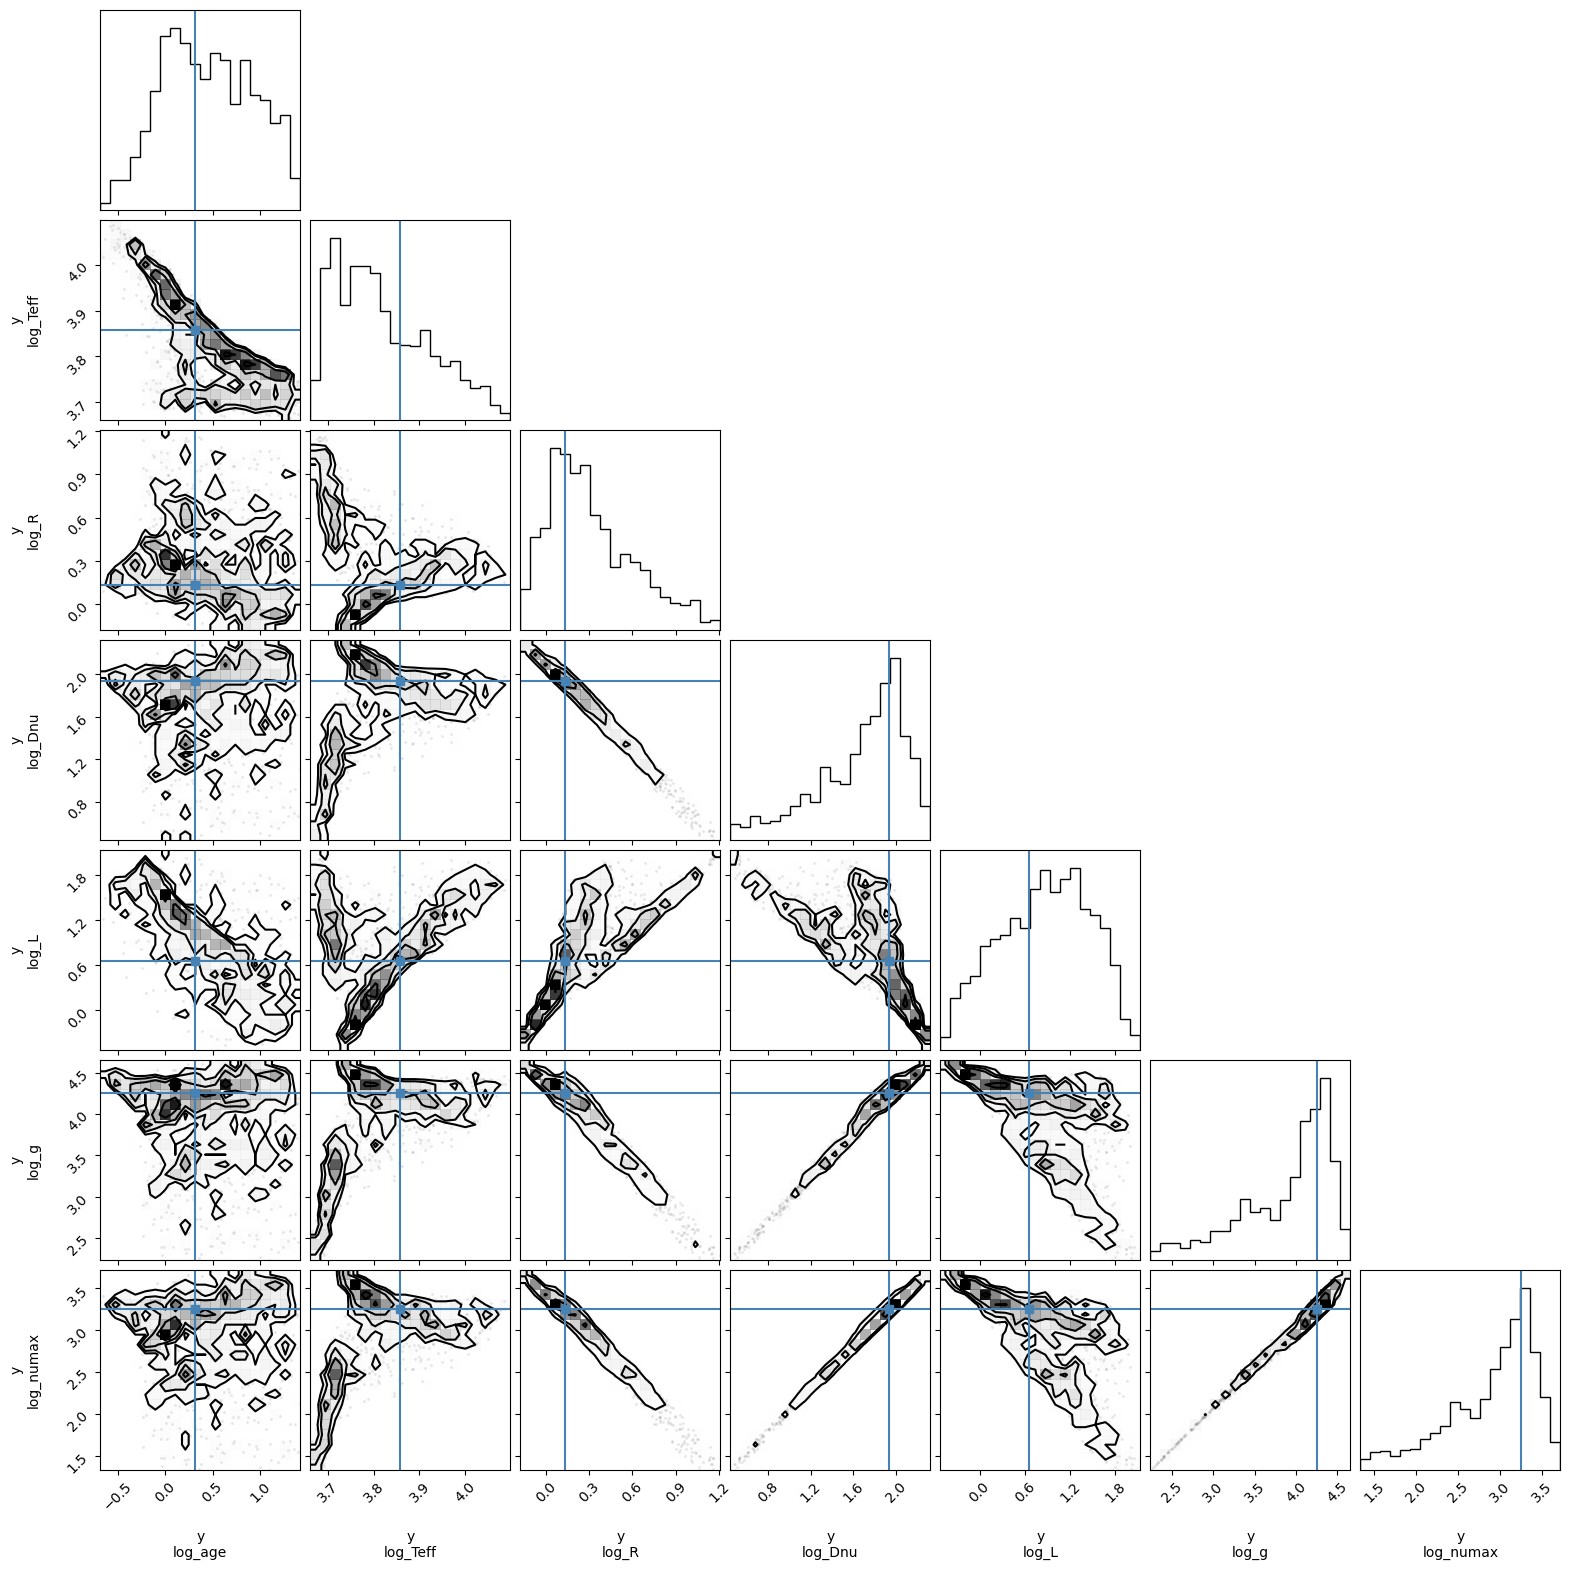

In [16]:
star = 0
var_names = "y"
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

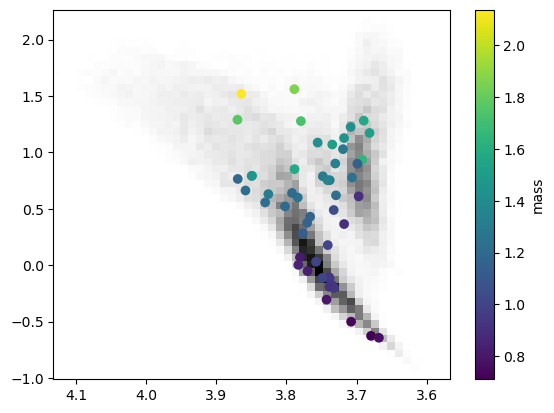

In [17]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.y.sel(output="log_Teff").values.ravel(), 
    data.prior.y.sel(output="log_L").values.ravel(), 
    bins=50, 
    cmap="Grays"
)
s = ax.scatter(
    truths["log_Teff"], 
    truths["log_L"], 
    c=truths["mass"]
)
ax.invert_xaxis()
fig.colorbar(s, label="mass");

## Observation

Now we synthesize observable parameters for the model.

In [18]:
rng, key = random.split(rng)

sigma = {}
sigma["log_Teff"] = 75. / truths["Teff"] / np.log(10)
sigma["log_L"] = 0.01 / np.log(10)

mean = np.stack([truths[param] for param in observables], -1)
sigma = np.stack(np.broadcast_arrays(*[sigma[param] for param in observables]), -1)

obs = mean + sigma * random.normal(key, shape=mean.shape)
print(obs)
print(sigma)

[[ 3.86248195e+00  6.65439504e-01]
 [ 3.87871927e+00  7.63724764e-01]
 [ 3.78938645e+00  1.55689484e+00]
 [ 3.74256039e+00 -1.17229713e-01]
 [ 3.77600013e+00  3.76782808e-01]
 [ 3.73563401e+00 -1.80285898e-01]
 [ 3.72119903e+00  1.02413163e+00]
 [ 3.73260000e+00  6.11312635e-01]
 [ 3.77463934e+00  6.77649421e-02]
 [ 3.79480510e+00  5.26081234e-01]
 [ 3.71686784e+00 -5.07703490e-01]
 [ 3.82570968e+00  6.31188552e-01]
 [ 3.78235899e+00  6.02252656e-01]
 [ 3.73842911e+00 -3.11559166e-01]
 [ 3.73877794e+00  4.80712462e-01]
 [ 3.69276646e+00  6.17748043e-01]
 [ 3.73641918e+00 -2.00361737e-01]
 [ 3.82858793e+00  5.60730930e-01]
 [ 3.67516100e+00 -6.27126706e-01]
 [ 3.86798415e+00  1.51494852e+00]
 [ 3.74570778e+00  7.91404091e-01]
 [ 3.86433452e+00  1.28716453e+00]
 [ 3.74913272e+00 -1.10243988e-01]
 [ 3.68644260e+00  9.29765512e-01]
 [ 3.71474153e+00  1.12598927e+00]
 [ 3.70635239e+00  9.05794577e-01]
 [ 3.84645957e+00  7.93790886e-01]
 [ 3.78274603e+00 -5.83981659e-02]
 [ 3.71276592e+00  1

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [19]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
# sampler = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median, find_heuristic_step_size=True, max_tree_depth=11)
sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(sampler, num_warmup=2000, num_samples=1000, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [20]:
rng, key = random.split(rng)
start = time()
with jax.default_device(gpu):
    mcmc.run(key, obs=obs, diag=sigma**2)
elapsed_time = time() - start
mcmc.print_summary()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
              M_H[0]     -0.57      0.10     -0.57     -0.73     -0.41   3610.57      1.00
              M_H[1]     -0.47      0.10     -0.47     -0.63     -0.30   3452.70      1.00
              M_H[2]     -0.51      0.10     -0.50     -0.67     -0.34   5261.26      1.00
              M_H[3]      0.41      0.10      0.41      0.26      0.57   8855.55      1.00
              M_H[4]      0.44      0.09      0.44      0.30      0.59   6842.96      1.00
              M_H[5]      0.37      0.10      0.37      0.22      0.53   7722.53      1.00
              M_H[6]     -0.85      0.10     -0.85     -1.02     -0.69   7758.76      1.00
              M_H[7]      0.15      0.10      0.15     -0.00      0.32   4382.39      1.00
              M_H[8]     -0.62      0.10     -0.62     -0.78     -0.45   6575.40      1.00
              M_H[9]      0.05      0.09      0.06     -0.10      0.21   4837.45      1.0

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [21]:
with jax.default_device(gpu):
    data += az.from_numpyro(mcmc, coords=coords, dims={k: v for k, v in dims.items() if k != "y"})
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

In [27]:
summary = az.summary(data, fmt="xarray")
summary

<xarray.Dataset>
Dimensions:           (star: 20, metric: 9)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/17)
    M_H               (metric, star) float64 -0.3191 -0.5708 ... 1.0 1.002
    Y                 (metric, star) float64 0.2573 0.2527 ... 1.003 1.001
    Y_0               (metric) float64 0.247 0.0009931 ... 6.765e+03 1.002
    Y_decentered      (metric, star) float64 0.04214 0.003357 ... 1.001 1.001
    a_MLT             (metric, star) float64 2.023 2.023 2.029 ... 1.002 1.001
    a_decentered      (metric, star) float64 0.01135 0.01184 ... 1.0 1.002
    ...                ...
    mu_a              (metric) float64 2.022 0.08995 1.853 ... 4.883e+03 1.002
    precision_Y       (metric) float64 3.178e+04 2.145e+04 ... 5.146e+03 1.0
    precision_a       (metric) float64 309.6 216.4 14.78 ... 5.127e+03 1.0
    scaled_precision  (metric, star) float64 0.9907 1.008 1.003 ... 1.001 1.0
    sigma_Y           (metric) float64 0.006763 0.002832 ... 5.146e+03 1.001
    sigma_a           (metric) float64 0.06986 0.03212 ... 5.127e+03 1.001

In [28]:
summary_nan = summary.where(summary.sel(metric="r_hat") < 1.1).to_array()
summary_nan

<xarray.DataArray (variable: 17, metric: 9, star: 20)>
array([[[-3.19050423e-01, -5.70809781e-01, -4.25308785e-01, ...,
         -1.97664754e-01,  1.41002520e-02,  3.38987956e-01],
        [ 9.13458313e-02,  9.93972764e-02,  9.82506946e-02, ...,
          9.15329643e-02,  8.46104648e-02,  9.45138731e-02],
        [-4.82758591e-01, -7.59124763e-01, -6.17296655e-01, ...,
         -3.75318902e-01, -1.40488354e-01,  1.63950166e-01],
        ...,
        [ 3.83389508e+03,  2.59813194e+03,  4.69505446e+03, ...,
          3.74420569e+03,  8.81128521e+03,  5.38336407e+03],
        [ 5.68716533e+03,  5.43089620e+03,  4.75545793e+03, ...,
          5.99846168e+03,  7.07181981e+03,  6.58501510e+03],
        [ 1.00067919e+00,  1.00267606e+00,  1.00125663e+00, ...,
          1.00096310e+00,  1.00025784e+00,  1.00200787e+00]],

       [[ 2.57290158e-01,  2.52727308e-01,  2.54927434e-01, ...,
          2.60433148e-01,  2.66447879e-01,  2.89496713e-01],
        [ 8.23753145e-03,  7.57197732e-03,  7.85202794e-03, ...,
          8.95894449e-03,  1.04419948e-02,  1.64382654e-02],
        [ 2.41096256e-01,  2.38356086e-01,  2.40808025e-01, ...,
          2.44110064e-01,  2.47844403e-01,  2.58438148e-01],
...
        [ 7.16658979e+03,  7.16658979e+03,  7.16658979e+03, ...,
          7.16658979e+03,  7.16658979e+03,  7.16658979e+03],
        [ 5.14617984e+03,  5.14617984e+03,  5.14617984e+03, ...,
          5.14617984e+03,  5.14617984e+03,  5.14617984e+03],
        [ 1.00078846e+00,  1.00078846e+00,  1.00078846e+00, ...,
          1.00078846e+00,  1.00078846e+00,  1.00078846e+00]],

       [[ 6.98639323e-02,  6.98639323e-02,  6.98639323e-02, ...,
          6.98639323e-02,  6.98639323e-02,  6.98639323e-02],
        [ 3.21195166e-02,  3.21195166e-02,  3.21195166e-02, ...,
          3.21195166e-02,  3.21195166e-02,  3.21195166e-02],
        [ 3.04890881e-02,  3.04890881e-02,  3.04890881e-02, ...,
          3.04890881e-02,  3.04890881e-02,  3.04890881e-02],
        ...,
        [ 8.11917299e+03,  8.11917299e+03,  8.11917299e+03, ...,
          8.11917299e+03,  8.11917299e+03,  8.11917299e+03],
        [ 5.12664948e+03,  5.12664948e+03,  5.12664948e+03, ...,
          5.12664948e+03,  5.12664948e+03,  5.12664948e+03],
        [ 1.00115100e+00,  1.00115100e+00,  1.00115100e+00, ...,
          1.00115100e+00,  1.00115100e+00,  1.00115100e+00]]])
Coordinates:
  * star      (star) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * metric    (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
  * variable  (variable) object 'M_H' 'Y' 'Y_0' ... 'sigma_Y' 'sigma_a'

In [29]:
summary_stacked = summary_nan.stack(x=["variable", "metric", "star"])
null_coords = summary_stacked[summary_stacked.isnull()].coords
bad_stars = set(null_coords["star"].values)
print(bad_stars)

set()


In [30]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [31]:
efficiency

<xarray.Dataset>
Dimensions:           (star: 20)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    metric            <U9 'ess_bulk'
Data variables: (12/17)
    M_H               (star) float64 11.39 7.72 13.95 21.29 ... 11.12 26.18 16.0
    Y                 (star) float64 22.54 25.36 22.09 ... 21.53 17.75 14.24
    Y_0               float64 37.45
    Y_decentered      (star) float64 27.08 27.67 26.25 ... 25.9 30.97 28.41
    a_MLT             (star) float64 14.35 14.12 12.51 ... 14.04 14.18 14.65
    a_decentered      (star) float64 32.66 32.13 30.57 ... 32.53 29.02 33.33
    ...                ...
    mu_a              float64 10.36
    precision_Y       float64 21.29
    precision_a       float64 24.12
    scaled_precision  (star) float64 25.36 27.5 26.22 25.4 ... 24.75 27.5 22.93
    sigma_Y           float64 21.29
    sigma_a           float64 24.12

In [32]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

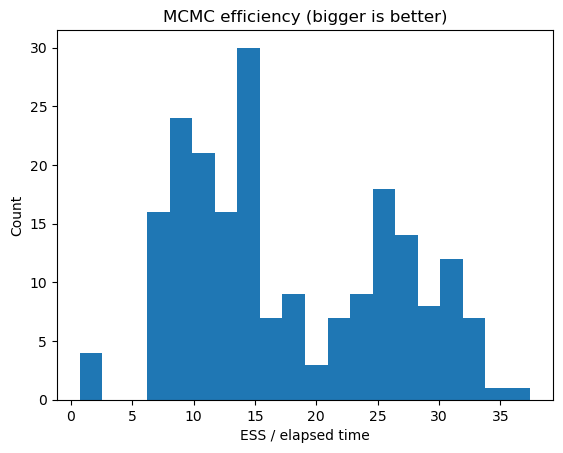

In [33]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

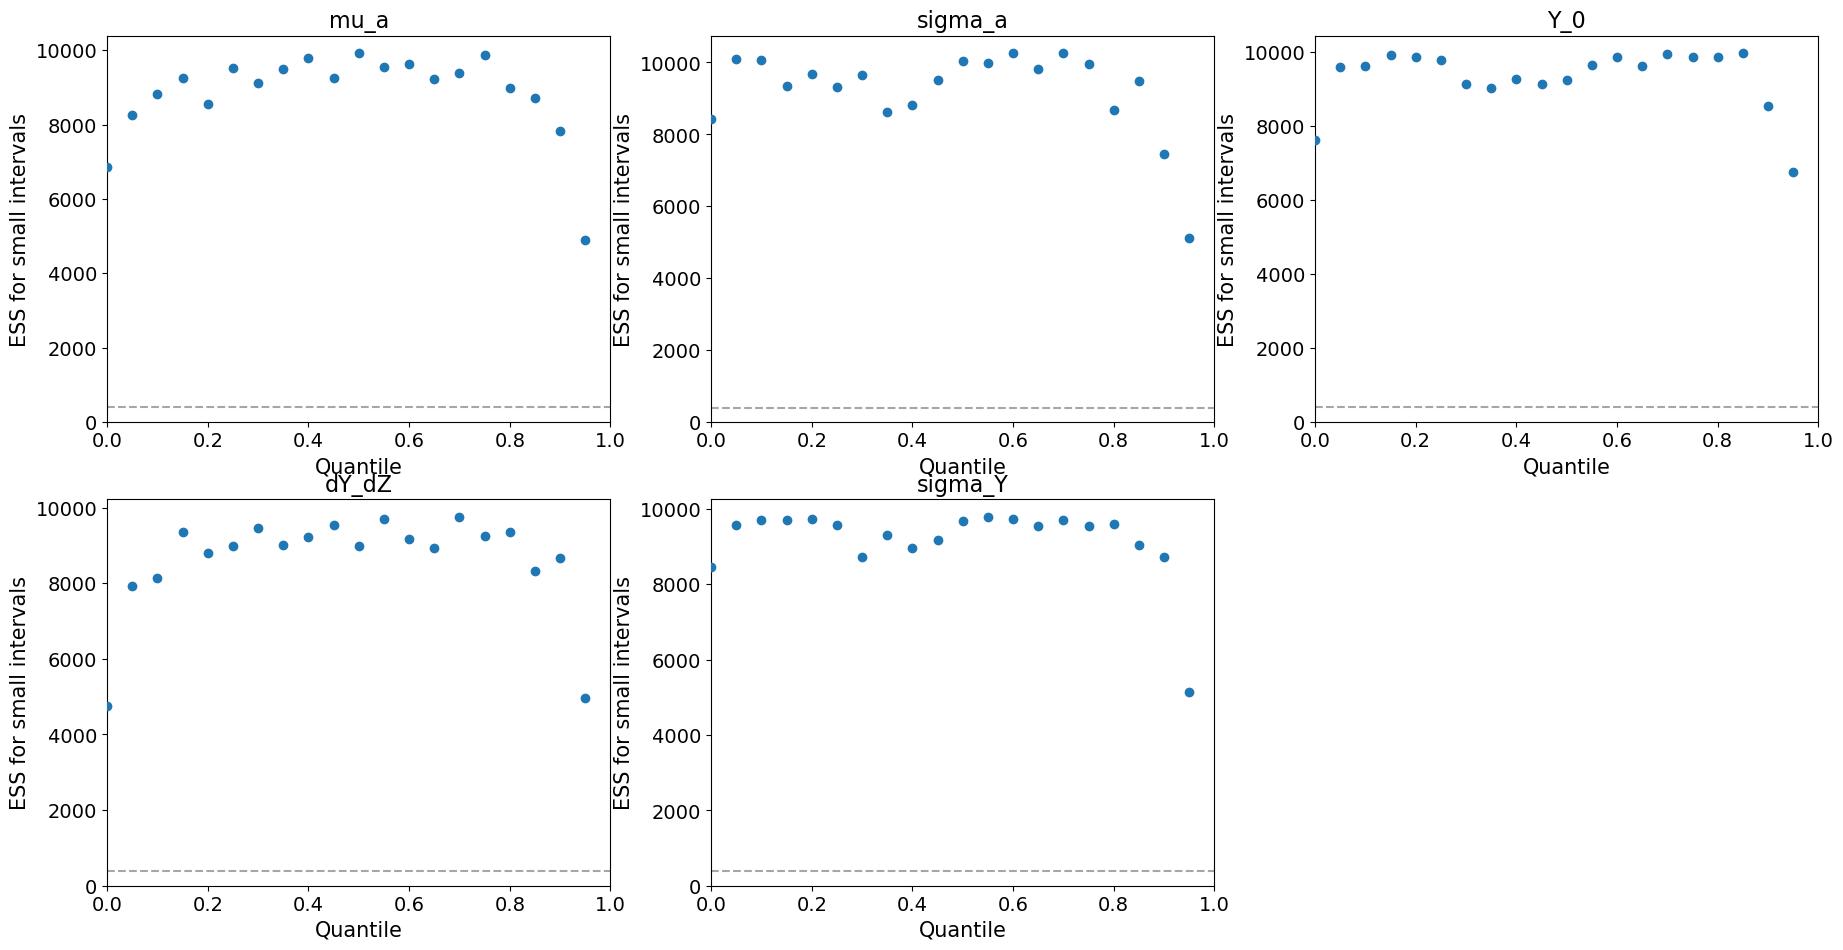

In [34]:
az.plot_ess(data, var_names=hyperparam_names);

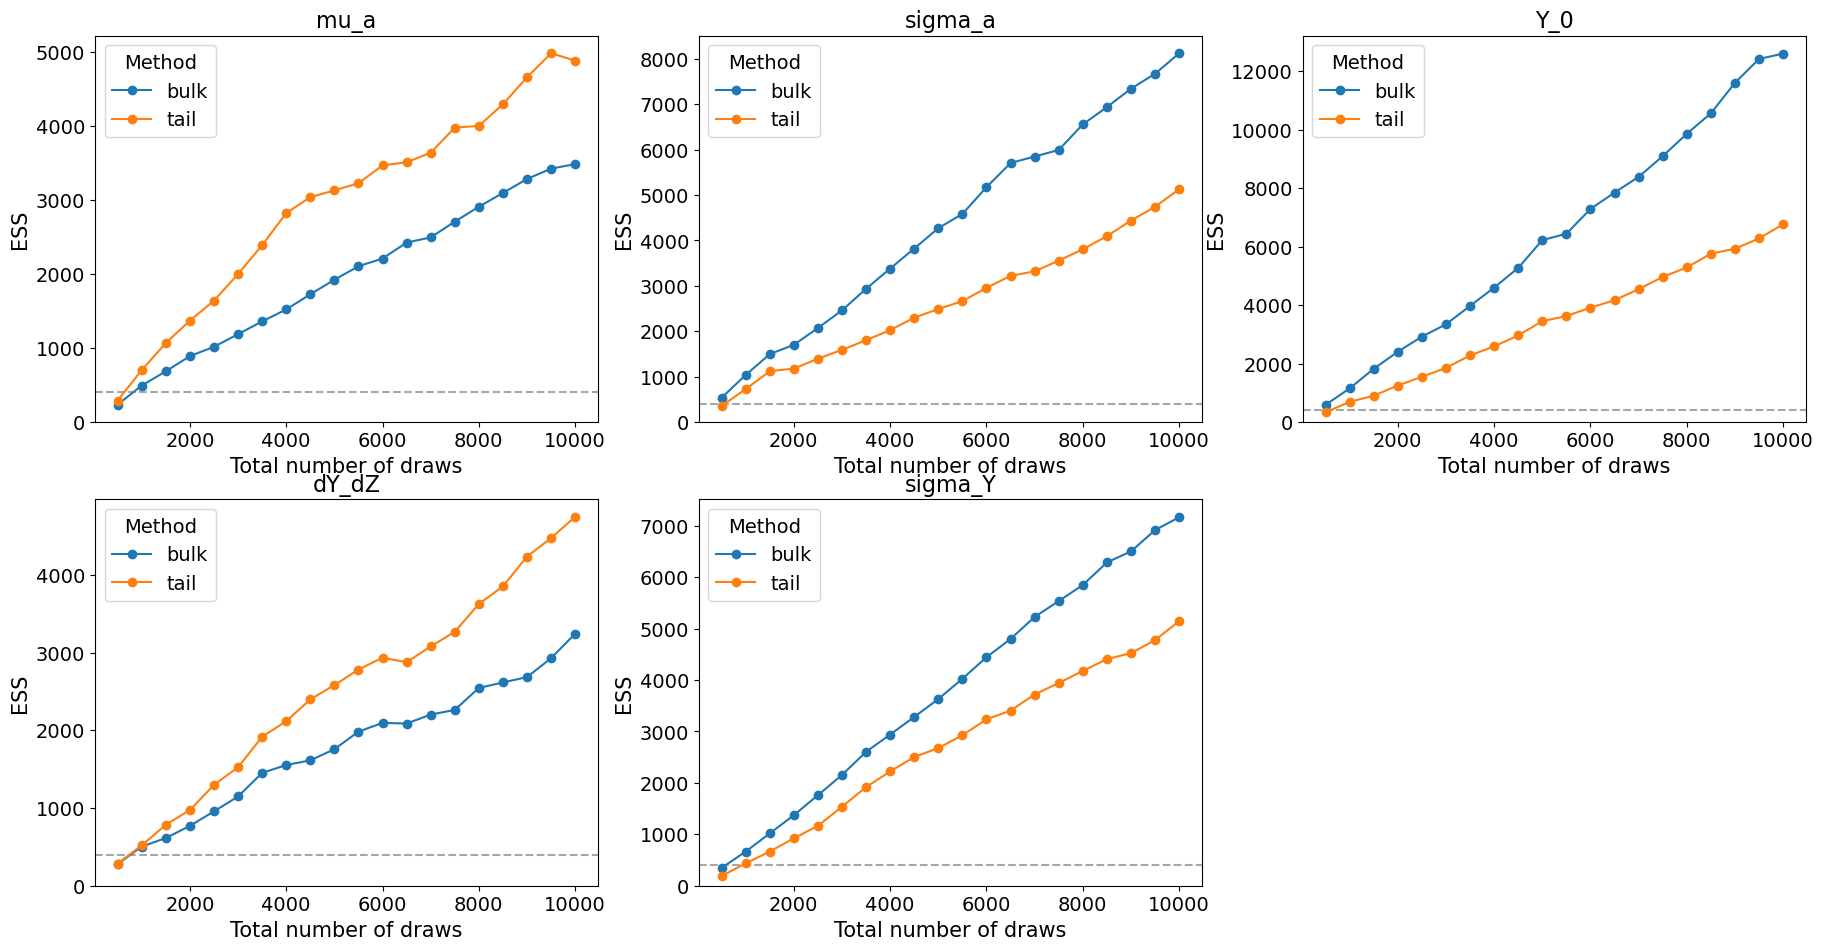

In [35]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

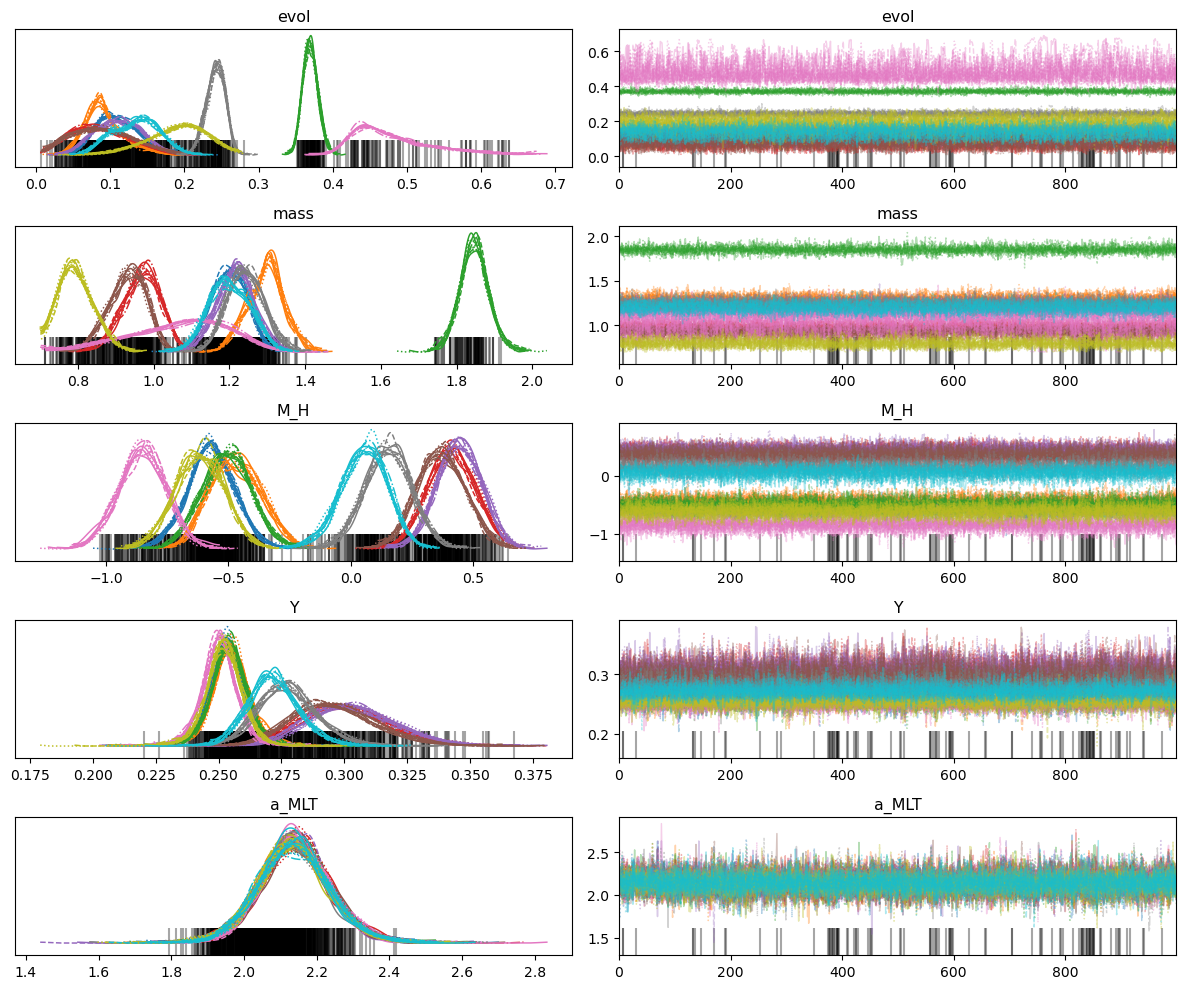

In [22]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(min(num_stars, 10))))
# az.plot_trace(data, var_names=var_names, coords=dict(star=good_stars[:10]))
plt.tight_layout()

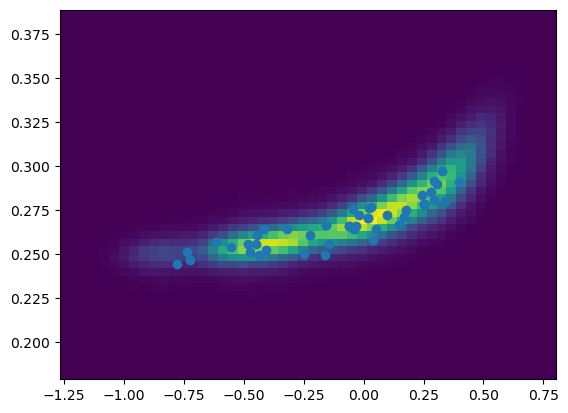

In [23]:
mh = data.posterior.M_H.values.flatten()
y = data.posterior.Y.values.flatten()
plt.hist2d(mh, y, bins=50)
plt.scatter(truths["M_H"], truths["Y"]);

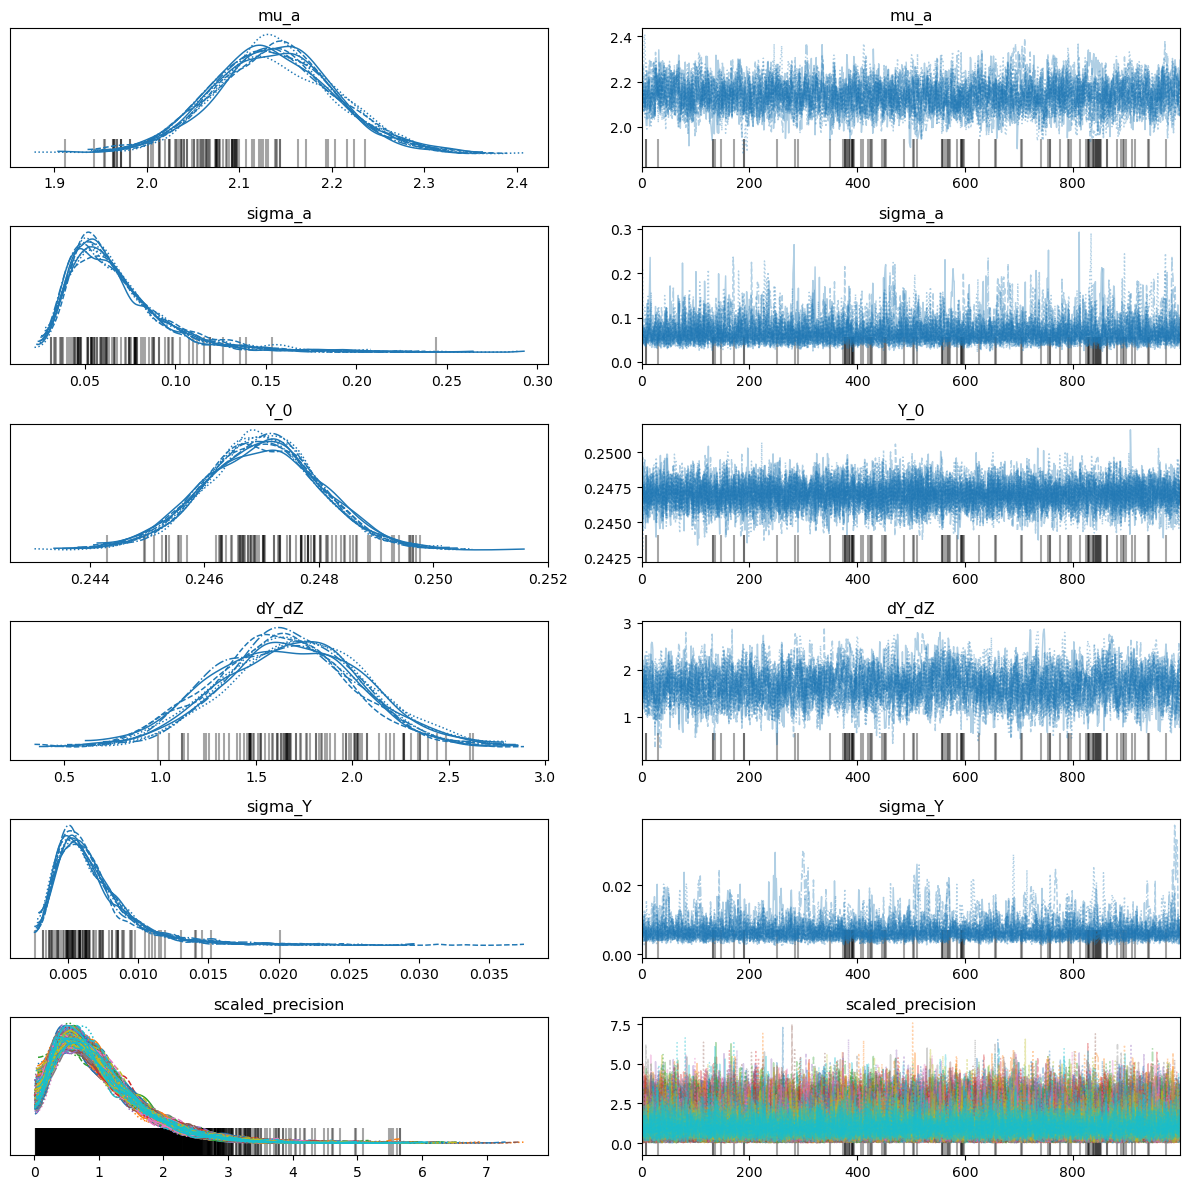

In [24]:
az.plot_trace(data, var_names=hyperparam_names+["scaled_precision"])
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

In [25]:
rng, key = random.split(rng)
posterior_predictive = Predictive(model, posterior_samples=mcmc.get_samples(), parallel=True, return_sites=["y"])
posterior_samples = posterior_predictive(key)

In [26]:
data += az.from_numpyro(posterior_predictive=posterior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

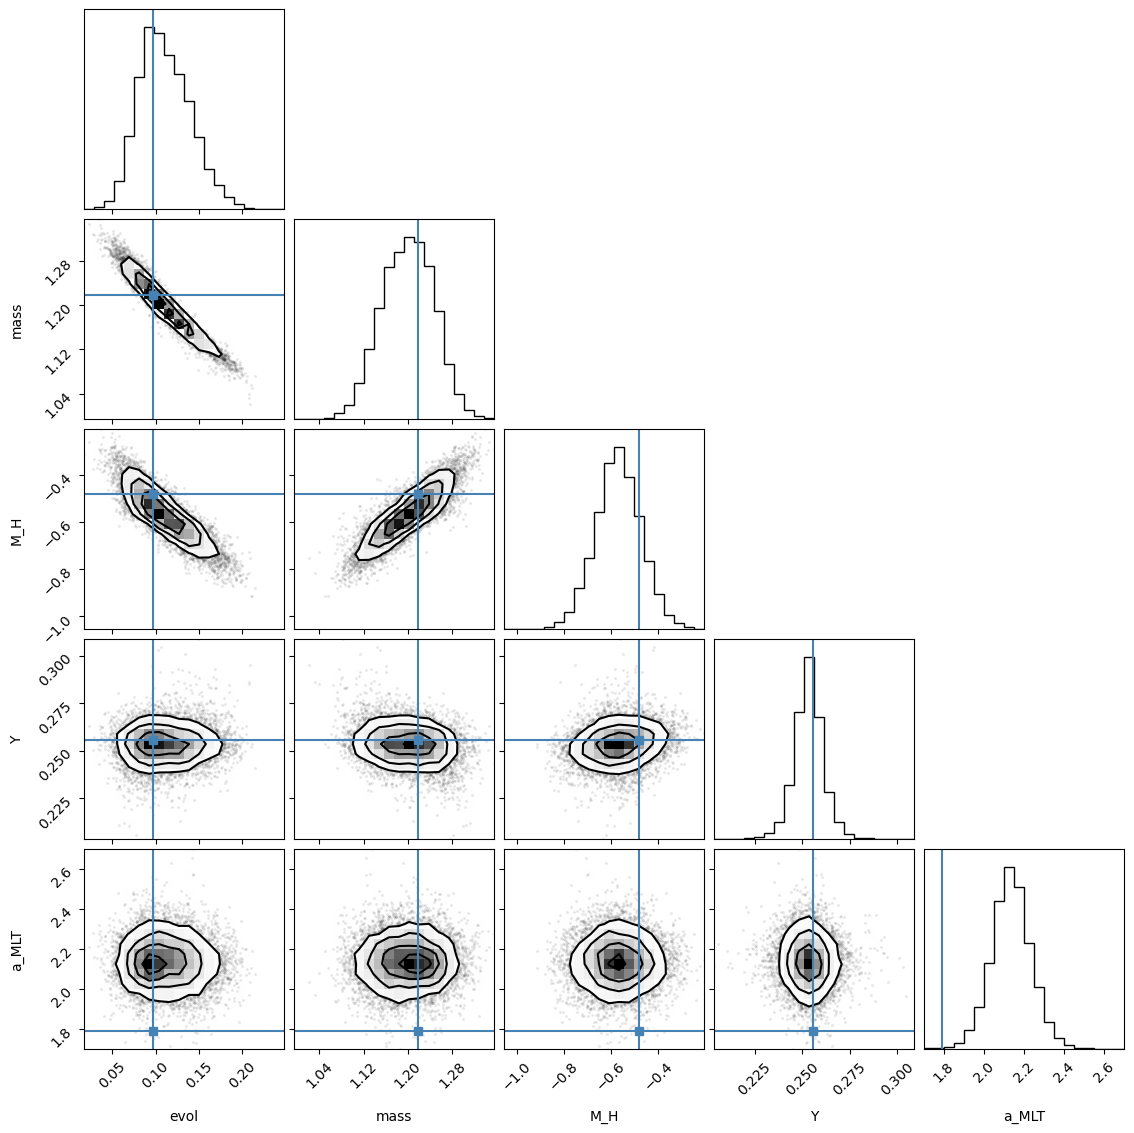

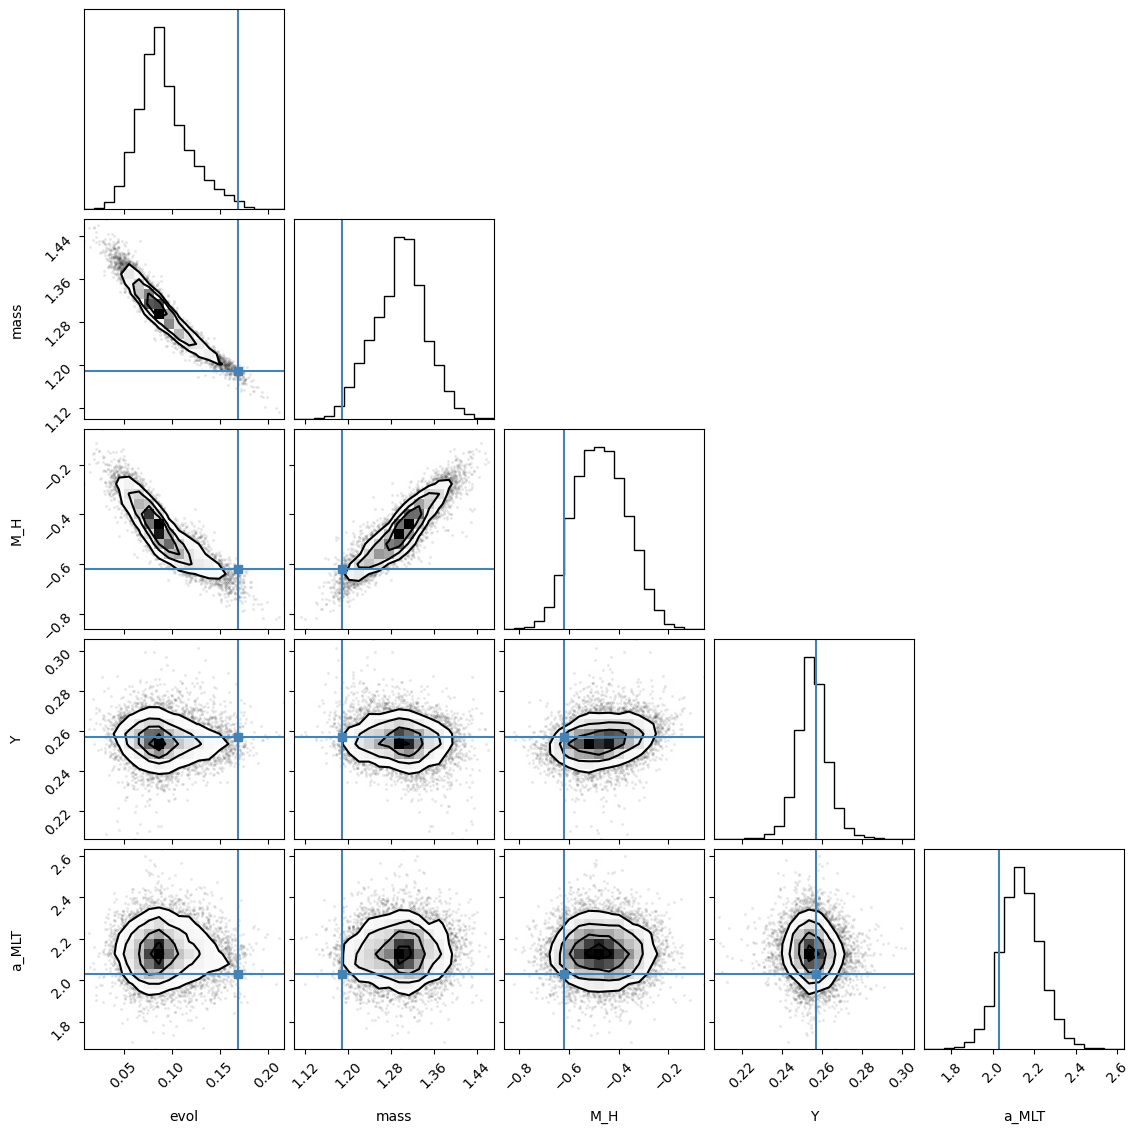

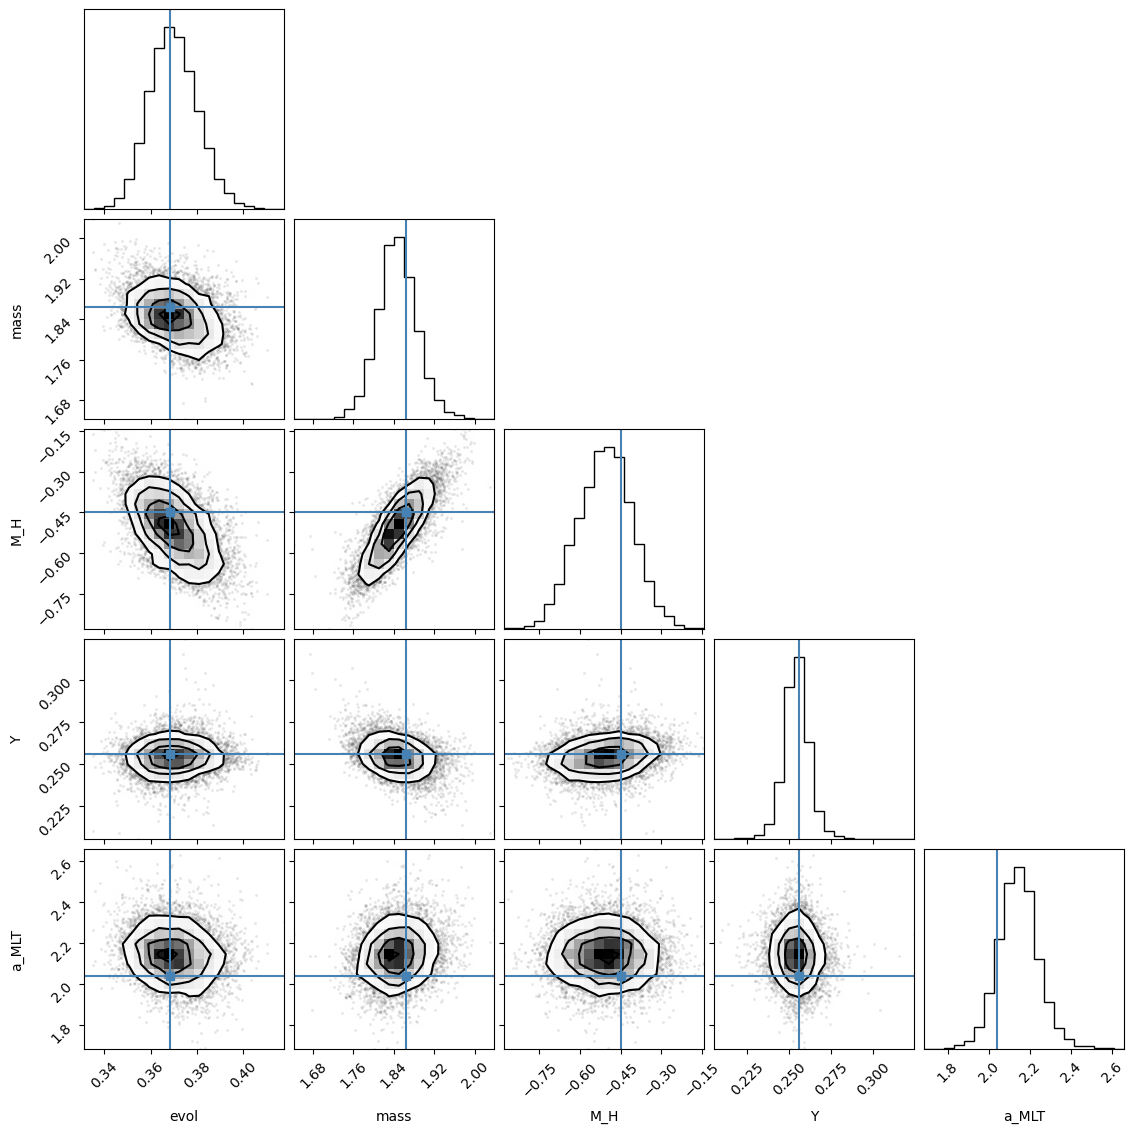

In [27]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

What do we predict for some deterministics?

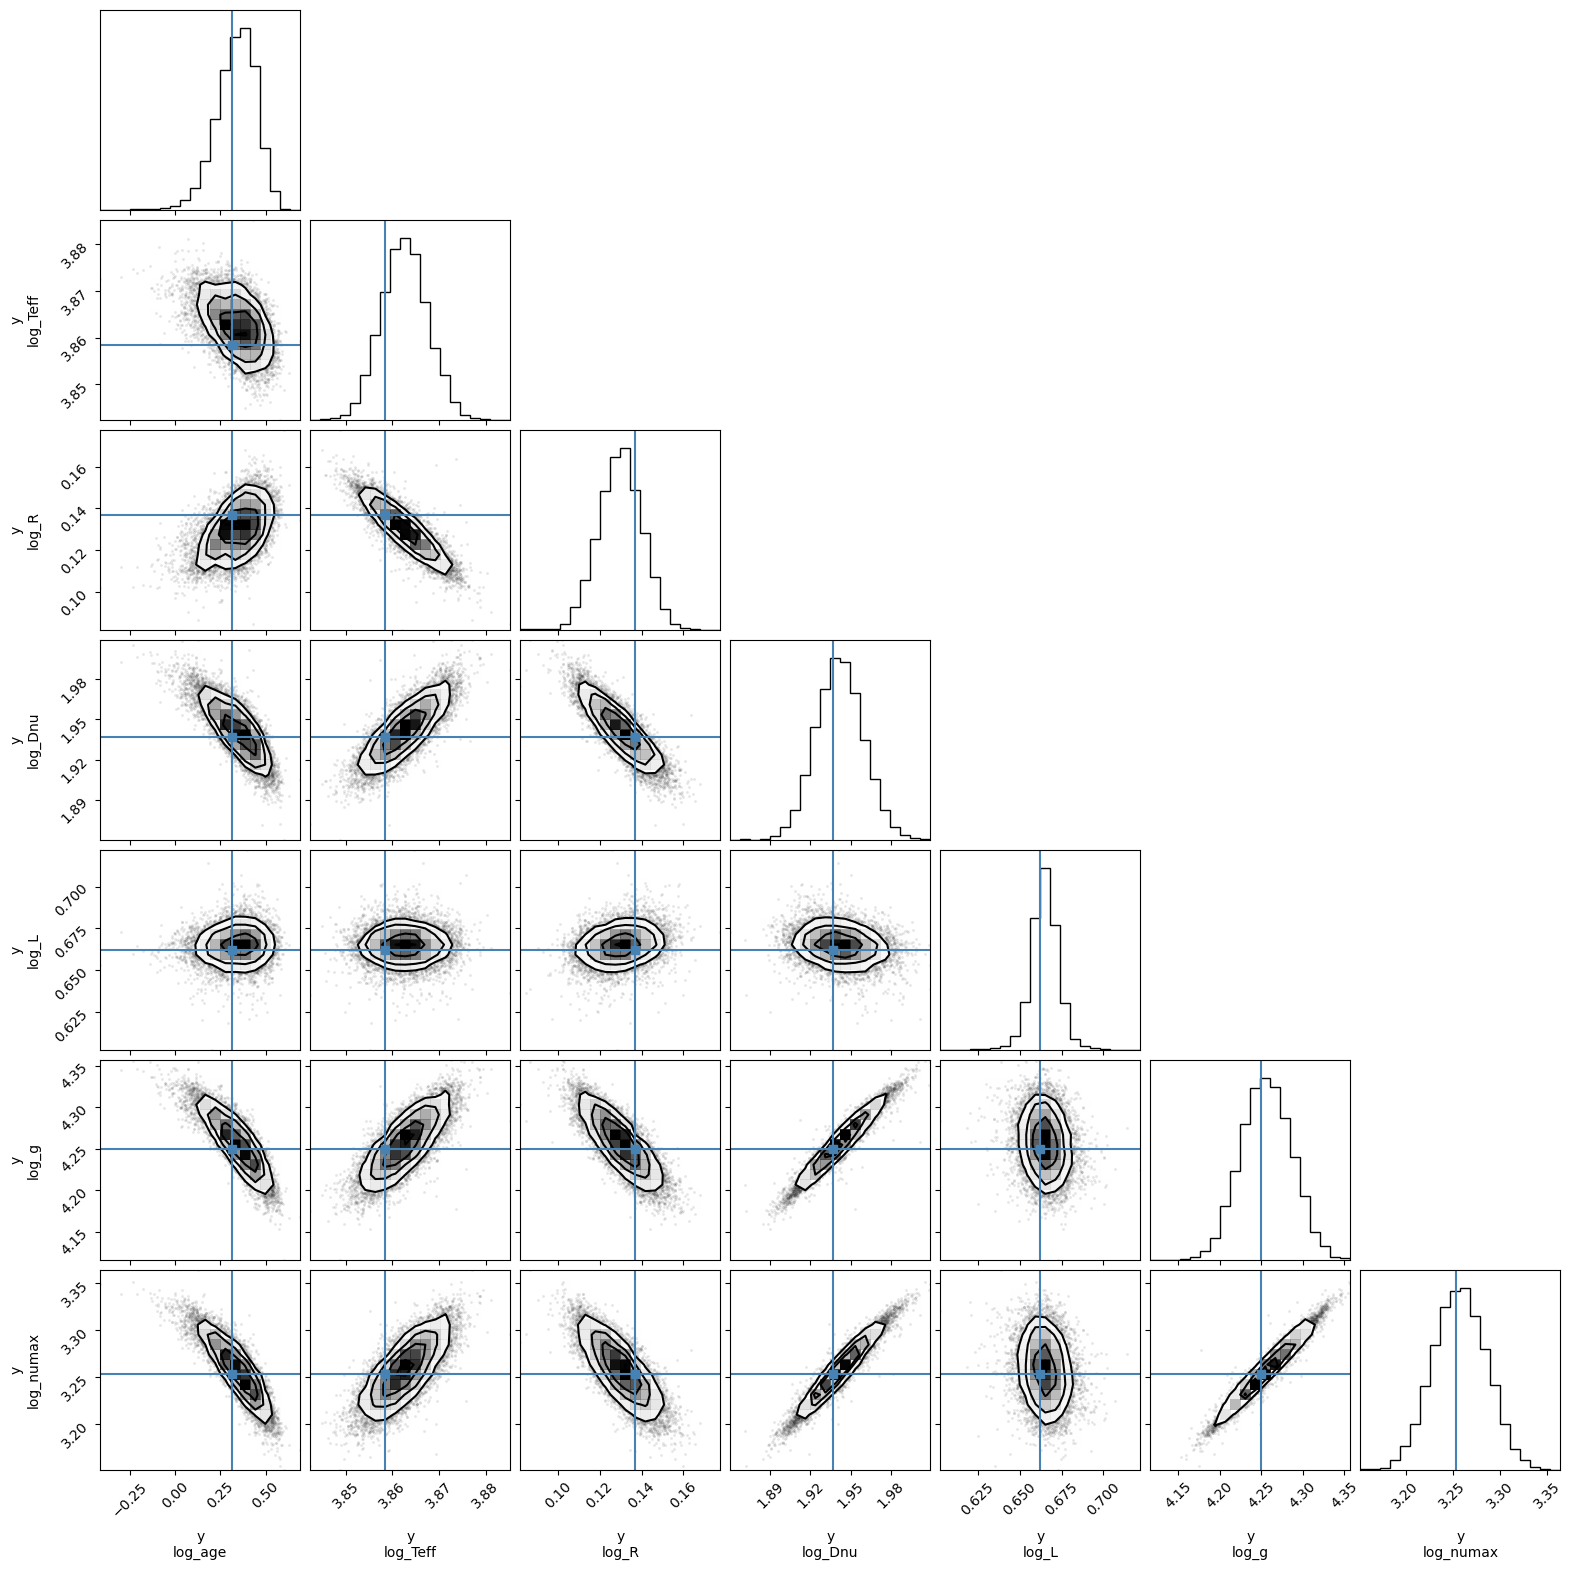

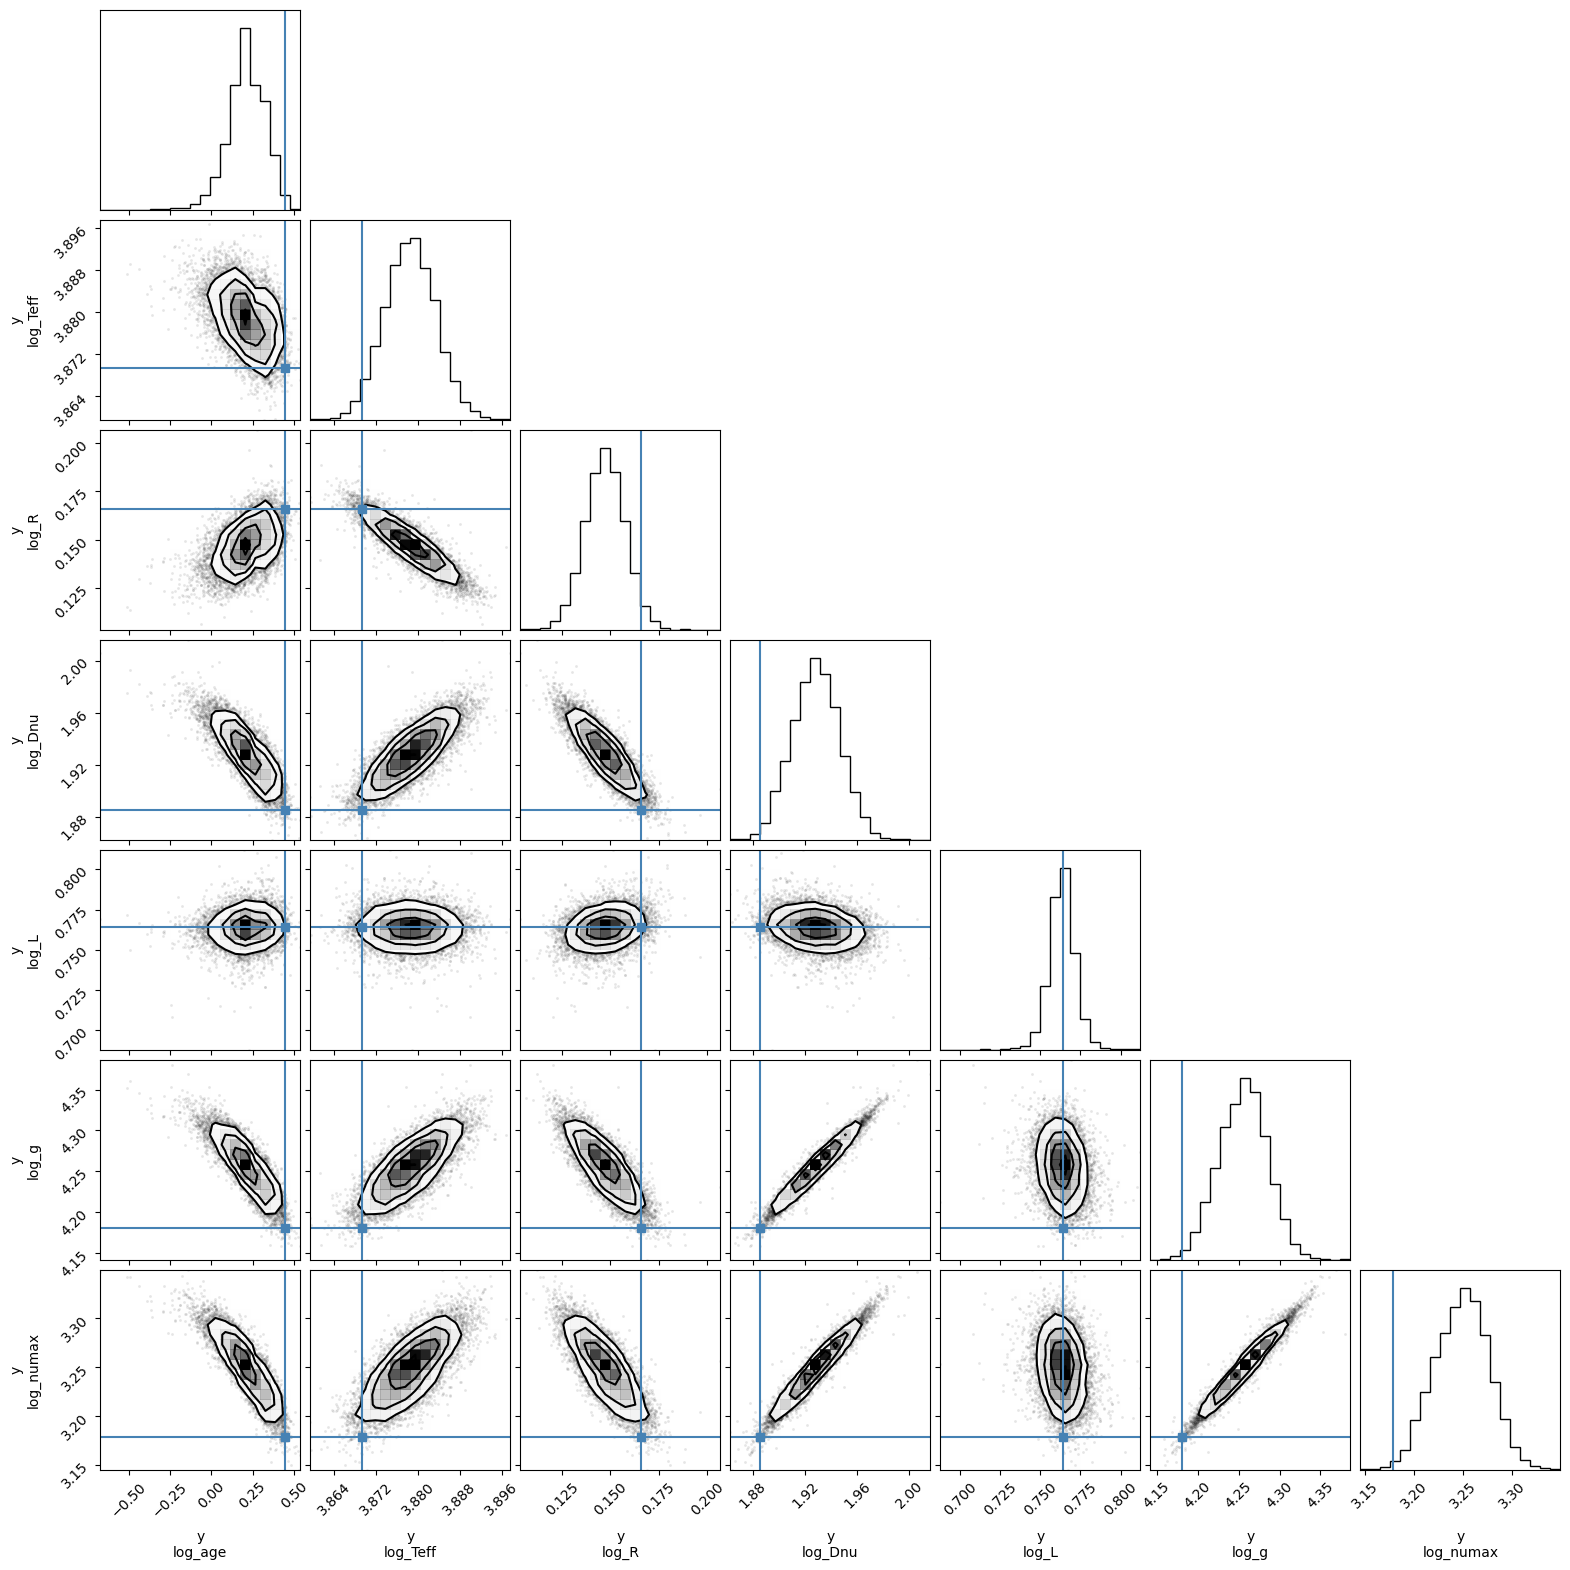

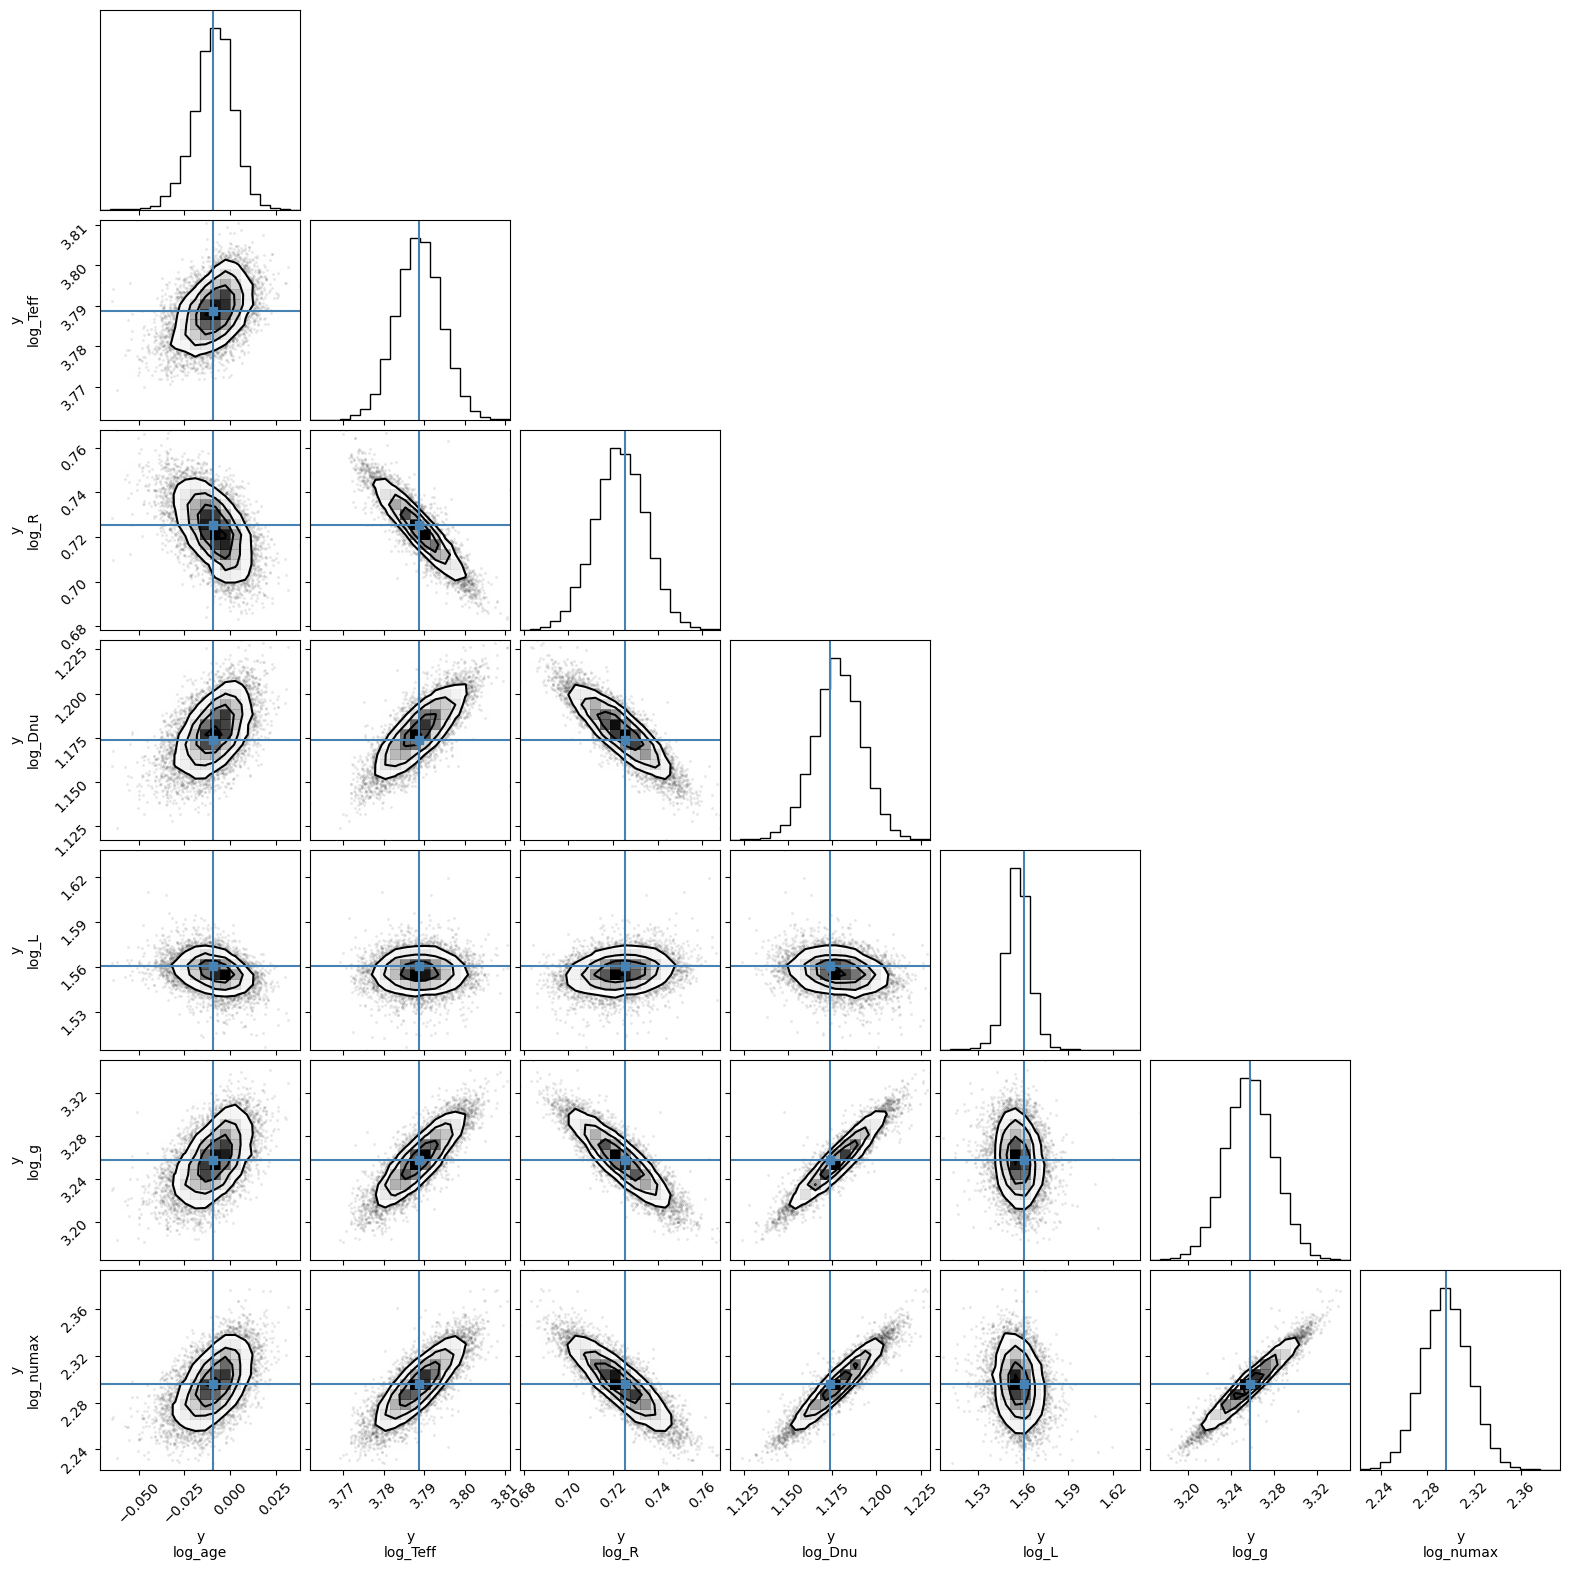

In [28]:
var_names = "y"
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior_predictive", var_names=var_names, truths=truths_, coords=coords_)

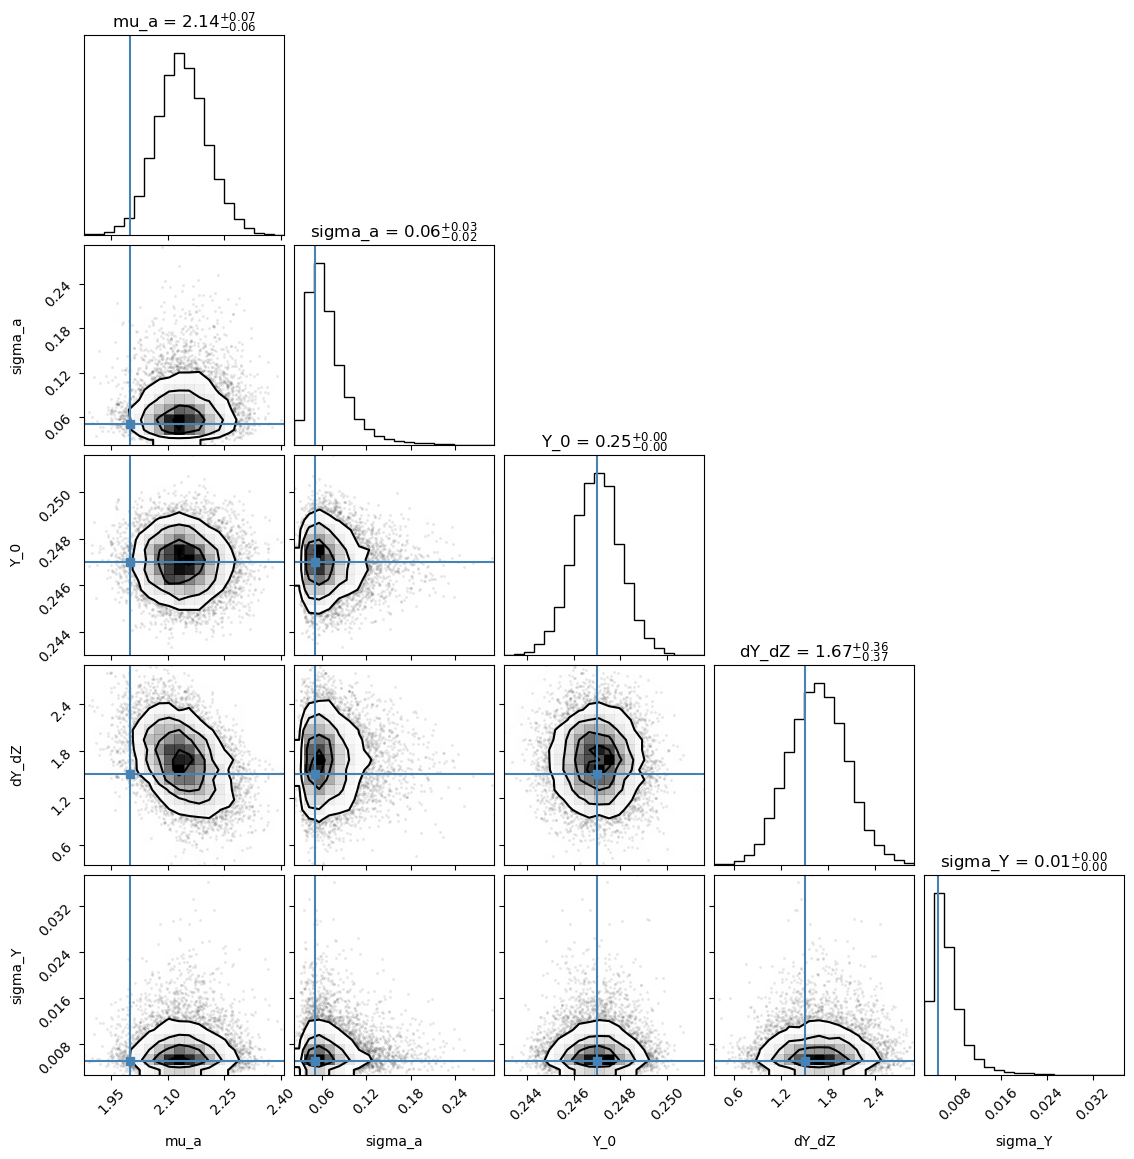

In [29]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths, show_titles=True)

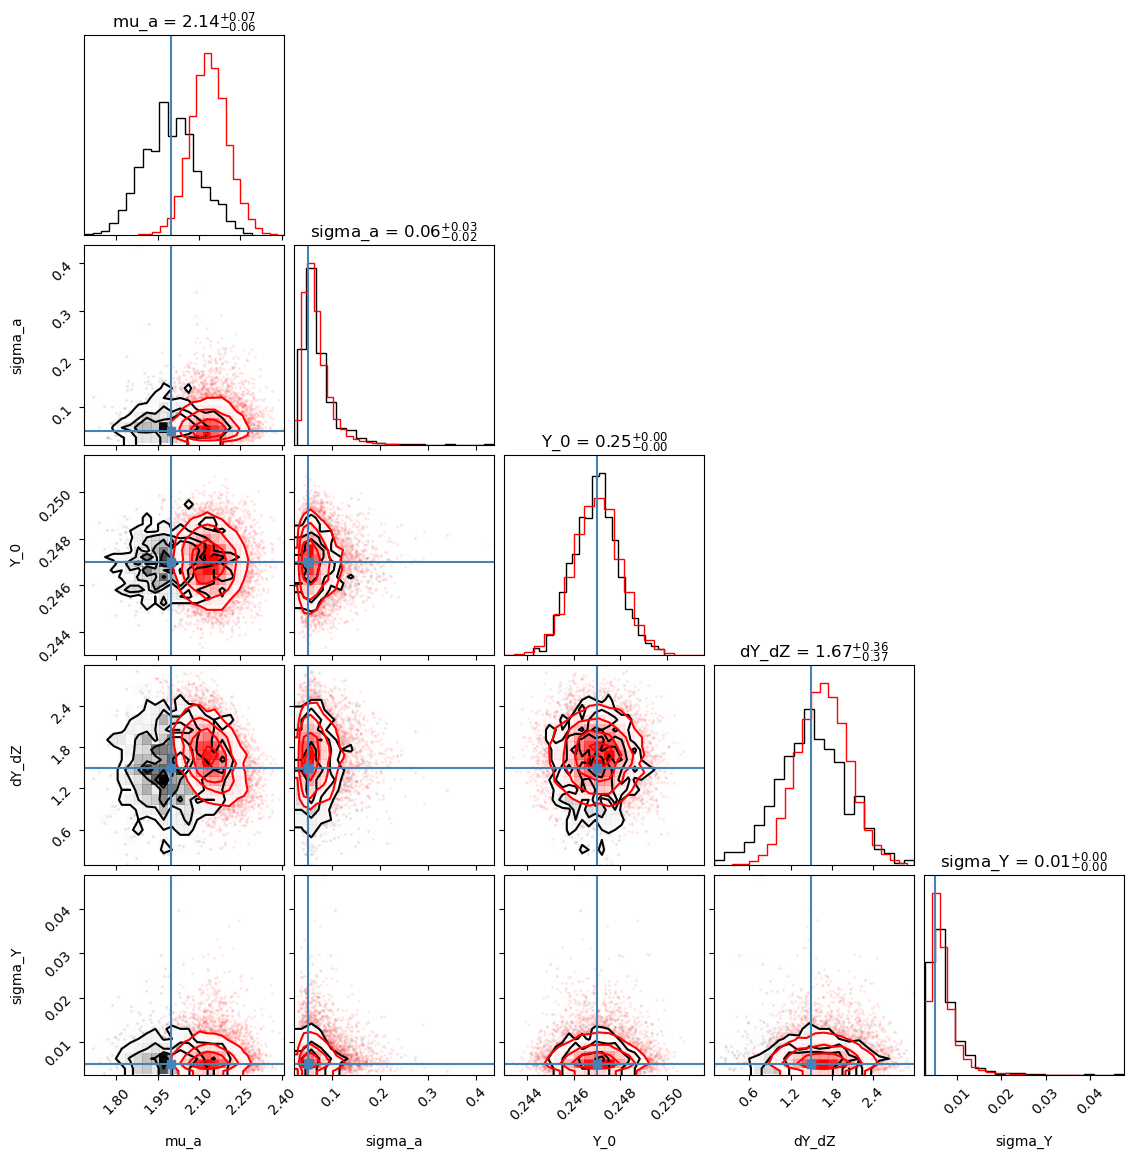

In [30]:
# limits = [(1.5, 2.5), (0.0, 0.4), (0.244, 0.250), (0.0, 3.0), (0.0, 0.04)]
limits = None
hist_kwargs = dict(density=True)
fig = corner(data, group="prior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs)

hist_kwargs["color"] = "r"
fig = corner(data, group="posterior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs,
             color="r", truths=truths, show_titles=True, fig=fig)


Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [31]:
mu_a = truths["a_MLT"].mean()
sigma_a = truths["a_MLT"].std(ddof=1)
error_on_mu = sigma_a / np.sqrt(num_stars)
print(mu_a, sigma_a, error_on_mu)

1.99028098 0.07302889548231536 0.010327845443621763


In [49]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]   -0.163  0.091  -0.339    0.001      0.001    0.001    3834.0   
M_H[1]   -0.046  0.099  -0.218    0.142      0.002    0.001    2598.0   
M_H[2]   -0.024  0.098  -0.201    0.168      0.001    0.001    4695.0   
M_H[3]   -0.043  0.097  -0.225    0.143      0.001    0.001    7165.0   
M_H[4]    0.079  0.100  -0.111    0.268      0.002    0.001    4177.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[18] -0.016  0.019  -0.049    0.011      0.000    0.000    4491.0   
mass[19] -0.010  0.056  -0.137    0.084      0.004    0.003     315.0   
mu_a     -0.022  0.090  -0.190    0.147      0.002    0.001    3485.0   
sigma_Y  -0.002  0.003  -0.007    0.002      0.000    0.000    7167.0   
sigma_a  -0.020  0.032  -0.075    0.020      0.000    0.000    8119.0   

          ess_tail  r_hat  
M_H[0]      5687.0   1.00  
M_H[1]      5431.0   1.00  
M_H[2]      4755.0   1.00  
M_H[3]      6726.0   1.00  
M_H[4]      4973.0   1.00  
...            ...    ...  
mass[18]    4596.0   1.00  
mass[19]     427.0   1.03  
mu_a        4883.0   1.00  
sigma_Y     5146.0   1.00  
sigma_a     5127.0   1.00  

[125 rows x 9 columns]

In [50]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]    0.338  0.190  -0.002    0.703      0.003    0.002    3834.0   
M_H[1]    0.074  0.161  -0.231    0.353      0.003    0.002    2598.0   
M_H[2]    0.053  0.219  -0.375    0.449      0.003    0.003    4695.0   
M_H[3]   -0.172  0.389  -0.900    0.572      0.005    0.004    7165.0   
M_H[4]    0.279  0.356  -0.392    0.950      0.006    0.004    4177.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[18] -0.022  0.027  -0.069    0.016      0.000    0.000    4491.0   
mass[19] -0.004  0.026  -0.064    0.039      0.002    0.001     315.0   
mu_a     -0.011  0.045  -0.095    0.073      0.001    0.001    3485.0   
sigma_Y  -0.353  0.566  -1.348    0.399      0.008    0.006    7167.0   
sigma_a  -0.397  0.642  -1.492    0.390      0.009    0.007    8119.0   

          ess_tail  r_hat  
M_H[0]      5687.0   1.00  
M_H[1]      5431.0   1.00  
M_H[2]      4755.0   1.00  
M_H[3]      6726.0   1.00  
M_H[4]      4973.0   1.00  
...            ...    ...  
mass[18]    4596.0   1.00  
mass[19]     427.0   1.03  
mu_a        4883.0   1.00  
sigma_Y     5146.0   1.00  
sigma_a     5127.0   1.00  

[125 rows x 9 columns]

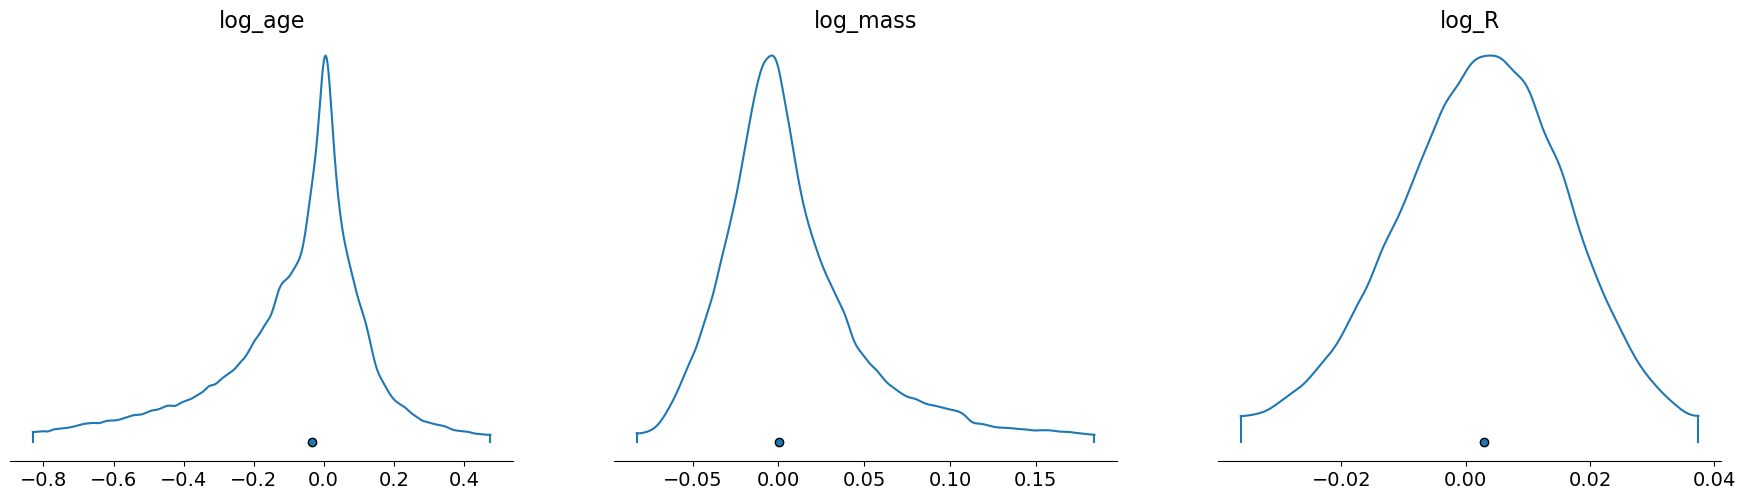

In [38]:
az.plot_density(error, var_names=["log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

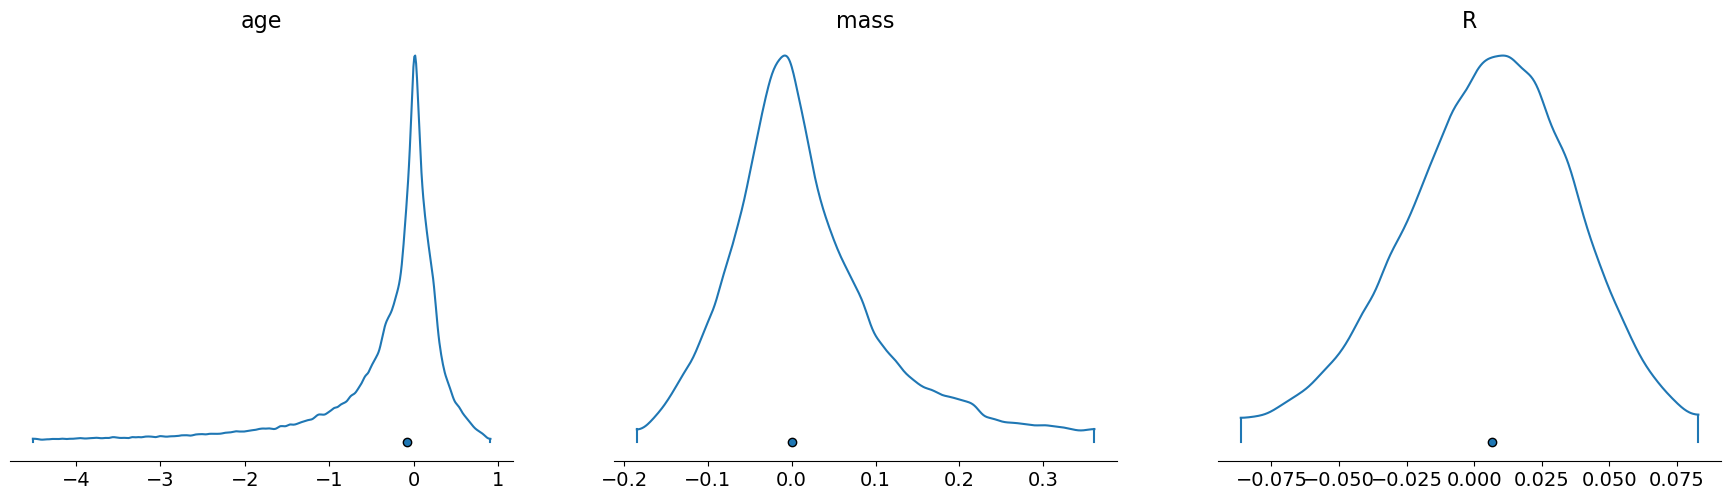

In [39]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

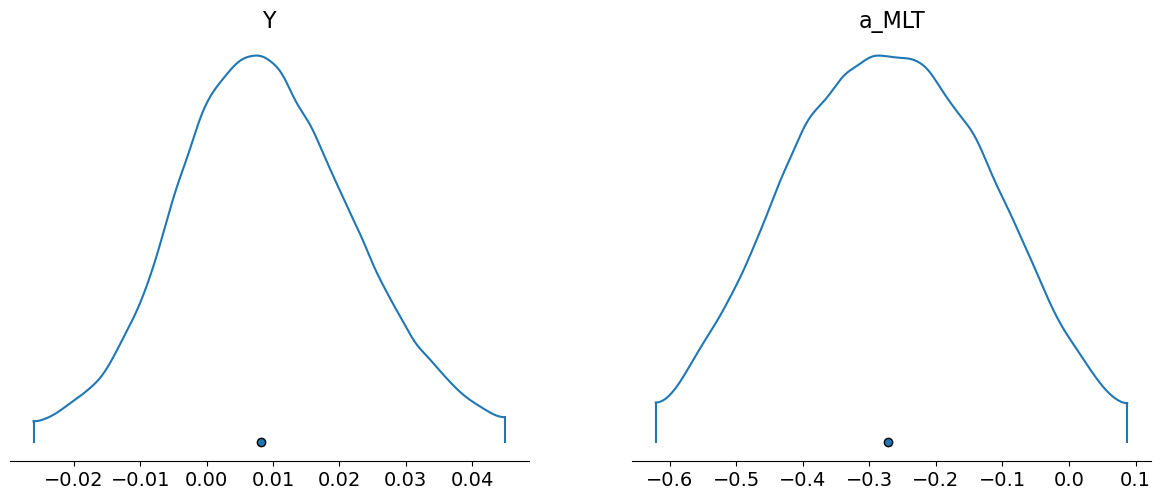

In [40]:
az.plot_density(error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

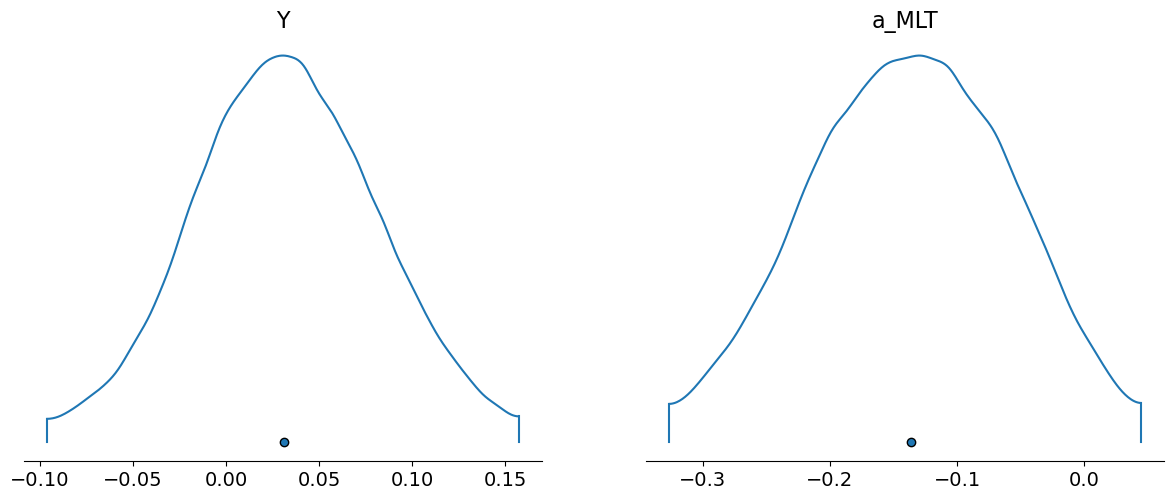

In [41]:
az.plot_density(fractional_error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

In [40]:
Y_decentered = truths["Y"] - truths["dY_dZ"] * truths["Zinit"] - truths["Y_0"]

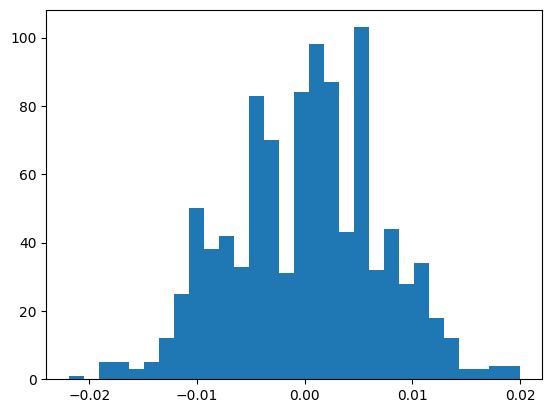

In [44]:
fig, ax = plt.subplots()
ax.hist(Y_decentered, bins=30);

In [43]:
mean = Y_decentered.mean()
sd = Y_decentered.std(ddof=1)
print(mean, sd)

0.000127728485000005 0.0069691380029937135


In [32]:
import numpyro.distributions as dist
import json, os
from celestify import PACKAGEDIR

In [33]:
with open(os.path.join(PACKAGEDIR, "data/emulator_error.json"), "r") as file:
    params = json.loads(file.read())

In [34]:
tril = np.array(params["L_omega"])
y = dist.MultivariateNormal(0.0, scale_tril=tril).sample(rng, sample_shape=(5000,))

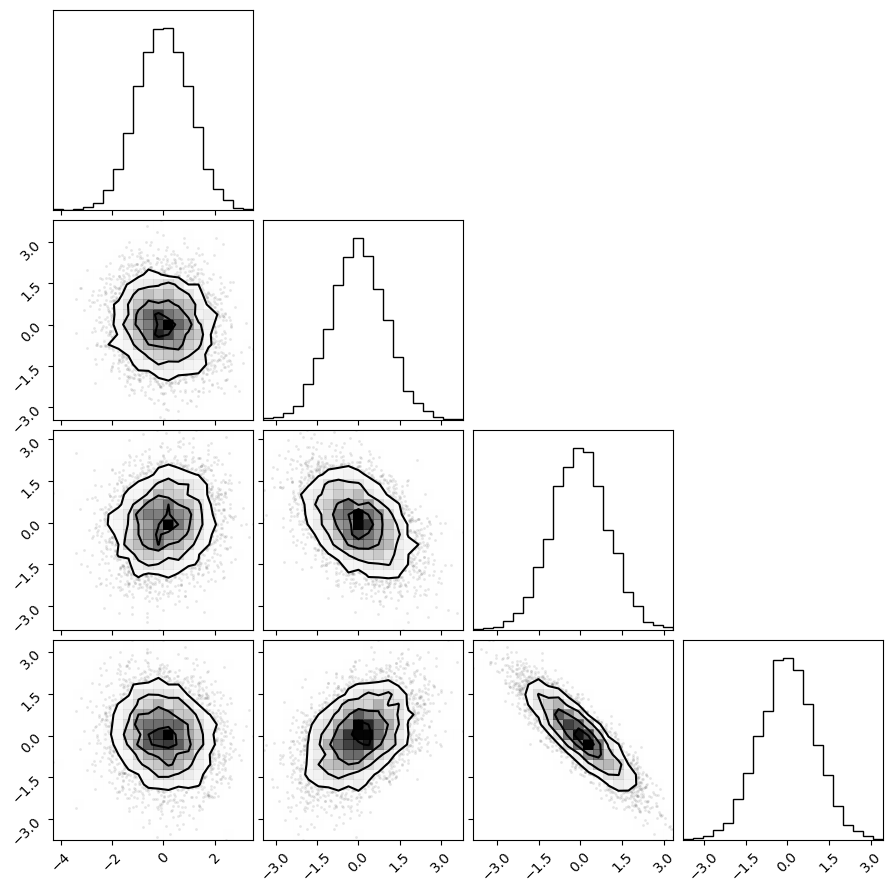

In [35]:
fig = corner(np.array(y))

In [36]:
scale = np.array(np.sqrt(params["theta"]))
df = np.array(params["df"])
precision = dist.Gamma(df/2., df/2.).sample(key, sample_shape=(5000,))

In [37]:
precision.shape

(5000,)

In [38]:
y_rescaled = np.array(params["mu"]) + scale / precision[:, None]**0.5 * y

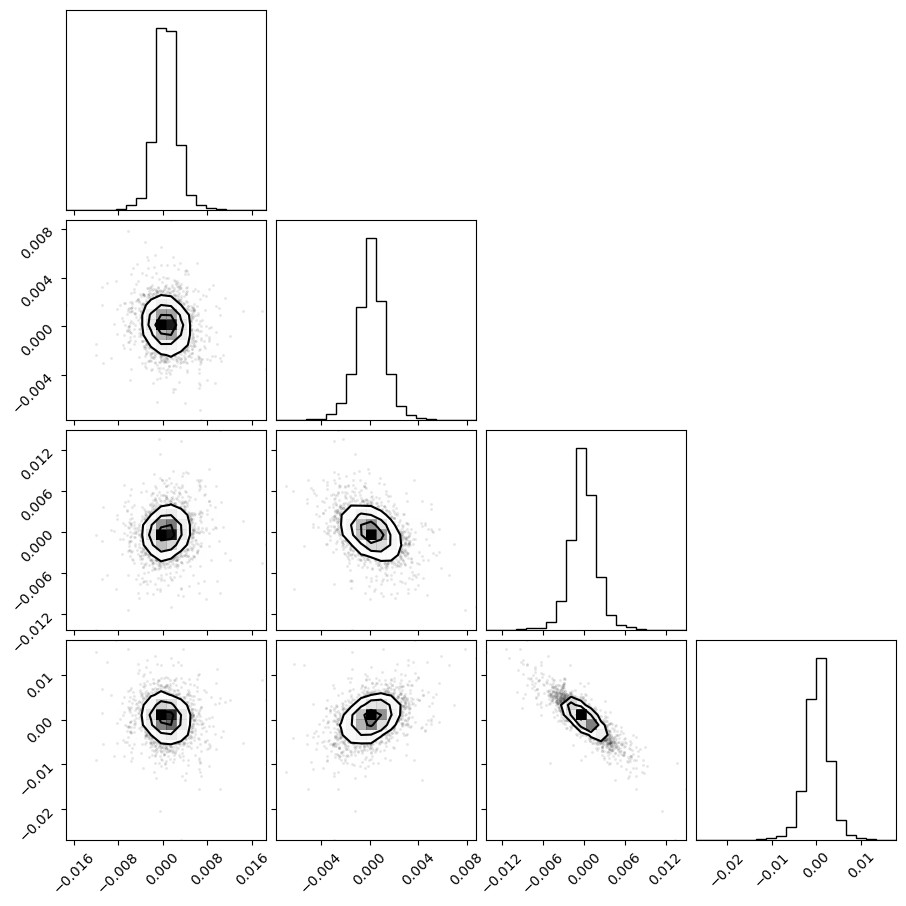

In [39]:
fig = corner(np.array(y_rescaled))

In [40]:
y_rescaled.mean(axis=0)

Array([ 5.96690200e-04,  1.20139316e-04, -6.34780692e-05,  3.25639357e-04],      dtype=float64)

In [41]:
np.quantile(y_rescaled, [.16, .5, .84], axis=0)

array([[-1.23076106e-03, -9.29330125e-04, -1.75329649e-03,
        -2.02208252e-03],
       [ 5.72614796e-04,  1.17620285e-04, -7.35444700e-05,
         3.77296980e-04],
       [ 2.41683728e-03,  1.18239849e-03,  1.64679126e-03,
         2.65793688e-03]])

In [42]:
tril

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-0.10934522,  0.99400383,  0.        ,  0.        ],
       [ 0.1475257 , -0.41157913,  0.8993547 ,  0.        ],
       [-0.12795591,  0.41253936, -0.74895447,  0.50249952]])

In [43]:
scale_tril = scale[:, None] * tril

In [44]:
cov = scale_tril @ scale_tril.T

In [45]:
np.sqrt(16 * cov[1, 1] + 4 * cov[2, 2] + 2 * 4 * 2 * cov[1, 2])

0.0036510590126178043

In [46]:
np.sqrt(16 * cov[1, 1] + 4 * cov[2, 2])

0.0047763392410090965

In [47]:
precision = np.ones(())

In [48]:
cov / precision[..., None, None]

array([[ 2.48329366e-06, -1.60093929e-07,  3.48753274e-07,
        -4.17365098e-07],
       [-1.60093929e-07,  8.63221086e-07, -5.92699039e-07,
         8.15505814e-07],
       [ 3.48753274e-07, -5.92699039e-07,  2.25046979e-06,
        -2.67737399e-06],
       [-4.17365098e-07,  8.15505814e-07, -2.67737399e-06,
         4.28433539e-06]])

In [53]:
covariance = cov[:2, :2]

In [63]:
mean = np.array([0.1, -0.2]) * np.ones((10, 2))
mean

array([[ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2]])

In [114]:
(mean.T * mean.T[:, None]).T * (covariance * np.ones((10, 2, 2)))

array([[[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]]])

In [100]:
np.swapaxes(mean[..., None], -1, -2).shape

(10, 1, 2)

In [85]:
from jax import vmap

In [88]:
vmap(lambda mean: mean * mean[:, None])(mean[0]).shape #* (np.exp(covariance) - 1)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [73]:
(covariance * np.ones((10, 2, 2))).shape

(10, 2, 2)

In [72]:
(mean * mean[..., None, None]).shape

(10, 2, 10, 2)

In [77]:
mean @ mean.T

array([[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]])

In [78]:
mean

array([[ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2]])